# Imports of necessary libraries

In [ ]:
from google.colab import drive
import shutil
import os
import pandas as pd
import requests
import dask.dataframe as dd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from math import sqrt
import joblib
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

try:
    import category_encoders
except ImportError:
    !pip install category_encoders

from category_encoders.target_encoder import TargetEncoder

# Mount Google Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# May use in case mount doesnt work anymore
# drive.flush_and_unmount()
# shutil.rmtree('/content/drive', ignore_errors=True)

#in drive
# info:

# chunks
# cleaned_chunks
# data
# cleaned_data
# sample.csv

Mounted at /content/drive


# Import data from website using the API in chunks

In [ ]:
# #Read the data from the website using the api, in batches.

# # API endpoint for the dataset
# url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json"

# # Define the chunk size
# chunk_size = 1000000
# offset = 0

# # Directory to save chunks in Google Drive
# output_dir = "/content/drive/MyDrive/Predict_response_time_project/dataset/chunks/"
# os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# # Find the largest offset already saved
# existing_chunks = [f for f in os.listdir(output_dir) if f.startswith("chunk_") and f.endswith(".csv")]
# if existing_chunks:
#     offsets = [int(f.split("_")[1].split(".")[0]) for f in existing_chunks]
#     offset = max(offsets) + chunk_size
#     print(f"Resuming from offset {offset}...")

# while True:
#     # Construct the API URL with $limit and $offset
#     api_url = f"{url}?$limit={chunk_size}&$offset={offset}"

#     # Fetch the data
#     print(f"Fetching rows {offset} to {offset + chunk_size}...")
#     response = requests.get(api_url)

#     # Check if the response is empty or invalid (end of data)
#     if response.status_code != 200 or len(response.json()) == 0:
#         print("No more data to fetch.")
#         break

#     # Convert the response to a DataFrame
#     chunk_df = pd.DataFrame(response.json())

#     # Save the chunk to Google Drive
#     chunk_file_path = os.path.join(output_dir, f"chunk_{offset}.csv")
#     chunk_df.to_csv(chunk_file_path, index=False)
#     print(f"Saved chunk {offset} to Google Drive.")

#     # Break the loop if fewer rows than the chunk size are returned
#     if len(chunk_df) < chunk_size:
#         print("Finished fetching all data.")
#         break

#     # Increment the offset
#     offset += chunk_size

Resuming from offset 27000000...
Fetching rows 27000000 to 28000000...
Saved chunk 27000000 to Google Drive.
Fetching rows 28000000 to 29000000...
Saved chunk 28000000 to Google Drive.
Fetching rows 29000000 to 30000000...
Saved chunk 29000000 to Google Drive.
Fetching rows 30000000 to 31000000...
Saved chunk 30000000 to Google Drive.
Fetching rows 31000000 to 32000000...
Saved chunk 31000000 to Google Drive.
Fetching rows 32000000 to 33000000...
Saved chunk 32000000 to Google Drive.
Fetching rows 33000000 to 34000000...
Saved chunk 33000000 to Google Drive.
Fetching rows 34000000 to 35000000...
Saved chunk 34000000 to Google Drive.
Fetching rows 35000000 to 36000000...
Saved chunk 35000000 to Google Drive.
Fetching rows 36000000 to 37000000...
Saved chunk 36000000 to Google Drive.
Fetching rows 37000000 to 38000000...
Saved chunk 37000000 to Google Drive.
Fetching rows 38000000 to 39000000...
Saved chunk 38000000 to Google Drive.
Fetching rows 39000000 to 40000000...
Saved chunk 39000

# Data Exploration

In [ ]:
#Read the dataset using dask

# Path to the directory containing all chunks
chunks_dir = "/content/drive/MyDrive/Predict_response_time_project/dataset/chunks/"

# Load all chunks lazily using Dask with specified dtypes
# df = dd.read_csv(os.path.join(chunks_dir, "chunk_*.csv"), dtype=dtype_dict)
df = dd.read_csv(os.path.join(chunks_dir, "chunk_*.csv"), dtype=object)

# Preview the first few rows
df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,...,taxi_pick_up_location,closed_date,resolution_description,bridge_highway_name,bridge_highway_direction,bridge_highway_segment,facility_type,road_ramp,due_date,taxi_company_borough
0,64367473,2025-03-16T01:23:50.000,NYPD,New York City Police Department,Non-Emergency Police Matter,Other (complaint details),Street/Sidewalk,10011,200 8 AVENUE,8 AVENUE,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,64365300,2025-03-16T01:23:50.000,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,10465,1023 THROGMORTON AVENUE,THROGMORTON AVENUE,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,64362105,2025-03-16T01:23:41.000,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,10463,3809 REVIEW PLACE,REVIEW PLACE,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,64362120,2025-03-16T01:23:39.000,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10128,405 EAST 92 STREET,EAST 92 STREET,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,64364330,2025-03-16T01:22:57.000,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,10039,85 BRADHURST AVENUE,BRADHURST AVENUE,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [ ]:
# Path to the directory containing all chunks
chunks_dir = "/content/drive/MyDrive/Predict_response_time_project/dataset/chunks/"

# Inspect one chunk to get the list of all columns
sample_chunk = pd.read_csv(os.path.join(chunks_dir, "chunk_0.csv"), nrows=1)
all_columns = sample_chunk.columns

# Create a dtype dictionary where all columns are 'object'
dtype_dict = {col: 'object' for col in all_columns}

# Remove the datetime columns from the dtype dictionary
datetime_columns = ['created_date']
for col in datetime_columns:
    dtype_dict.pop(col, None)  # Remove the column if it exists

# Load all chunks lazily using Dask with specified dtypes
df = dd.read_csv(
    os.path.join(chunks_dir, "chunk_*.csv"),
    dtype=dtype_dict,  # Use the dynamically generated dtype dictionary
    parse_dates=datetime_columns  # Parse these columns as datetime
)

# Check the data types of the columns
print("\nData Types After Loading:")
print(df.dtypes)


Data Types After Loading:
unique_key                        string[pyarrow]
created_date                       datetime64[ns]
agency                            string[pyarrow]
agency_name                       string[pyarrow]
complaint_type                    string[pyarrow]
descriptor                        string[pyarrow]
location_type                     string[pyarrow]
incident_zip                      string[pyarrow]
incident_address                  string[pyarrow]
street_name                       string[pyarrow]
cross_street_1                    string[pyarrow]
cross_street_2                    string[pyarrow]
intersection_street_1             string[pyarrow]
intersection_street_2             string[pyarrow]
address_type                      string[pyarrow]
city                              string[pyarrow]
landmark                          string[pyarrow]
status                            string[pyarrow]
resolution_action_updated_date    string[pyarrow]
community_board        

In [ ]:
#Checking the columns of the dataset
print("Columns:", df.columns)

Columns: Index(['unique_key', 'created_date', 'agency', 'agency_name', 'complaint_type',
       'descriptor', 'location_type', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'landmark', 'status', 'resolution_action_updated_date',
       'community_board', 'bbl', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', ':@computed_region_efsh_h5xi',
       ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q',
       ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih',
       ':@computed_region_7mpf_4k6g', 'vehicle_type', 'taxi_pick_up_location',
       'closed_date', 'resolution_description', 'bridge_highway_name',
       'bridge_highway_direction', 'bridge_highway_segment', 'facility_type',
       'road_ram

In [ ]:
# Count the number of rows (16min)
rows = len(df)
columns = df.shape[1]

print(f"In this dataframe, we have {rows} rows and {columns} columns.")

KeyboardInterrupt: 

# Pre Processing techniques and Operations that will be done later once for all

## Dropping unecessary columns

In [ ]:
#Unecessary columns that should be dropped
# columns_to_drop = [
# 'bridge_highway_name', 'bridge_highway_direction', 'bridge_highway_segment',
# 'road_ramp', 'x_coordinate_state_plane', 'y_coordinate_state_plane',
# 'intersection_street_1', 'intersection_street_2', 'taxi_pick_up_location',
# 'taxi_company_borough', 'vehicle_type', 'landmark',
# ':@computed_region_efsh_h5xi', ':@computed_region_f5dn_yrer',
# ':@computed_region_yeji_bk3q', ':@computed_region_92fq_4b7q',
# ':@computed_region_sbqj_enih', ':@computed_region_7mpf_4k6g',
# 'facility_type']

#Will do the operations later once for all
# df = df.drop(columns=columns_to_drop)

# #Checking the columns of the dataset
# print("Columns:", df.columns)

## Calculating total missing values and their percentages to decide how to deal with them

In [ ]:
# Calculate total missing values and their percentages for all columns (1h40min)

# missing_values = df.isnull().sum()  # Total missing values per column
# total_rows = 38873274              # (Already calculated) (Wrote it manually to save time)
# missing_percentage = (missing_values / total_rows) * 100  # Percentage of missing values

# # Combine into a single DataFrame for better readability
# missing_info = pd.DataFrame({
#     'Total Missing': missing_values,
#     'Percentage Missing (%)': missing_percentage
# }).sort_values(by='Percentage Missing (%)', ascending=False)

# # Display the combined missing value information
# print(missing_info)


# output was:
#     Total Missing  Percentage Missing (%)
# 27       37952218               97.630619
# 26       33710142               86.718042
# 25       27786063               71.478577
# 11       10878433               27.984350
# 13       10856379               27.927617
# 7         7160544               18.420224
# 10        6967162               17.922756
# 9         6445343               16.580397
# 14        6119015               15.740930
# 12        4742065               12.198780
# 8         3818151                9.822046
# 17        3237220                8.327624
# 18        2992010                7.696830
# 24        2644034                6.801676
# 23        2580644                6.638607
# 22        1948634                5.012786
# 6         1596711                4.107478
# 19        1279132                3.290518
# 15        1237729                3.184010
# 20        1171547                3.013760
# 21         980244                2.521640
# 16         897242                2.308120
# 2          708032                1.821385
# 5          116243                0.299031
# 4               0                0.000000
# 0               0                0.000000
# 1               0                0.000000
# 3               0                0.000000

In [ ]:
# List columns with their index numbers
# for index, column_name in enumerate(df.columns):
#     print(f"Index {index}: {column_name}")


# output was:
# Index 0: unique_key
# Index 1: created_date
# Index 2: agency
# Index 3: agency_name
# Index 4: complaint_type
# Index 5: descriptor
# Index 6: location_type
# Index 7: incident_zip
# Index 8: incident_address
# Index 9: street_name
# Index 10: cross_street_1
# Index 11: cross_street_2
# Index 12: address_type
# Index 13: city
# Index 14: status
# Index 15: resolution_action_updated_date
# Index 16: community_board
# Index 17: bbl
# Index 18: borough
# Index 19: open_data_channel_type
# Index 20: park_facility_name
# Index 21: park_borough
# Index 22: latitude
# Index 23: longitude
# Index 24: location
# Index 25: closed_date
# Index 26: resolution_description
# Index 27: due_date

##columns that has the most na values: closed_date, resolution_description, due_date should be dropped
##closed_date 27,786,063 null values - 71.478577 % - 26 (index)
##resolution_description - 33,710,142 null values - 86.718042 % - 27 (index)
##due_date - 37,952,218 null values - 97.630619 %

## Dealing with null values

In [ ]:
# Dealing with na values / Converting columns to their datatypes before dealing with na values - Will do the operations later once for all
# df['agency'] = df['agency'].fillna("Unknown")
# df['descriptor'] = df['descriptor'].fillna("Unknown")
# df['location_type'] = df['location_type'].fillna("Unknown")
# df['incident_zip'] = df['incident_zip'].fillna("Unknown")
# df['cross_street_1'] = df['cross_street_1'].fillna("Unknown")
# df['cross_street_2'] = df['cross_street_2'].fillna("Unknown")
# df['address_type'] = df['address_type'].fillna("Unknown")
# df['city'] = df['city'].fillna("Unknown")
# df['status'] = df['status'].fillna("Unknown")
# df['community_board'] = df['community_board'].fillna("Unknown")
# df['bbl'] = df['bbl'].fillna("Unknown")
# df['borough'] = df['borough'].fillna("Unknown")
# df['open_data_channel_type'] = df['open_data_channel_type'].fillna("Unknown")
# df['park_facility_name'] = df['park_facility_name'].fillna("Unknown")
# df['park_borough'] = df['park_borough'].fillna("Unknown")
# df['latitude'] = df['latitude'].fillna("Unknown")
# df['longitude'] = df['longitude'].fillna("Unknown")
# df['location'] = df['location'].fillna("Unknown")
# df['incident_address'] = df['incident_address'].fillna("Unknown")
# df['street_name'] = df['street_name'].fillna("Unknown")

# # Drop rows where 'resolution_action_updated_date' is missing
# df = df.dropna(subset=['resolution_action_updated_date']).compute()

In [ ]:
#Dropping columns having more than 70% of them na values - will do the operations later once for all
# df = df.drop(columns=['resolution_description'])
# df = df.drop(columns=['closed_date'])
# df = df.drop(columns=['due_date'])

## Response time target column creation

In [ ]:
#Will do the operations later once for all

# # Convert the column to datetime
# df['resolution_action_updated_date'] = df['resolution_action_updated_date'].map_partitions(
#     lambda pdf: pd.to_datetime(pdf, format='%Y-%m-%dT%H:%M:%S.%f', errors='coerce')
# )

# df.head()

In [ ]:
# Check data types of the relevant columns
# print("Data Types Before Calculation:")
# print(df[['created_date', 'resolution_action_updated_date']].dtypes)

In [ ]:
#Will do this operation later once for all
# df['response_time'] = (
#     df['resolution_action_updated_date'] - df['created_date']
# ) / pd.Timedelta(minutes=1)

In [ ]:
# Compute the DataFrame to inspect results
# df_computed = df.compute()

# Preview the first few rows with response time
# print("\nFirst Few Rows with Response Time:")
# print(df[['created_date', 'resolution_action_updated_date', 'response_time']].head())

## Duplicates

In [ ]:
#Duplicates check
# import dask.dataframe as dd

# # Step 1: Group by all columns and count occurrences
# duplicate_counts = df.groupby(list(df.columns)).size()

# # Step 2: Filter counts > 1 (indicating duplicates)
# duplicate_counts = duplicate_counts[duplicate_counts > 1]

# # Step 3: Compute the total number of duplicate rows
# total_duplicates = duplicate_counts.sum().compute()

# # Step 4: Display the total number of duplicate rows
# print(f"Total number of duplicate rows: {total_duplicates}")

## Outliers

In [ ]:
# Inspect the response time column to decide our cap of response time (to remove outliers from it)
# df_sample = df.sample(frac=0.0005, random_state=42).compute()  # Convert to Pandas

# print("\nResponse Time Summary:")
# print(df_sample['response_time'].describe())

# # Step 1: Convert response_time to numeric
# df_sample['response_time'] = pd.to_numeric(df_sample['response_time'], errors='coerce')

# # Step 2: Drop rows with NaN values in response_time
# df_sample = df_sample.dropna(subset=['response_time'])

# # Step 3: Generate summary statistics
# response_time_summary = df_sample['response_time'].describe()

# # Step 4: Print the summary in the desired format
# print(response_time_summary)


#Output:
# count           19218.0
# mean       29641.257104
# std       178359.196936
# min            -70560.0
# 25%                89.0
# 50%              1410.0
# 75%             8818.55
# max      5534946.216667
# Name: response_time, dtype: Float64

In [ ]:
#Outliers

# # Define the numeric columns to convert
# numeric_columns = ['response_time']

# df['response_time'] = df['response_time'].astype('float64')

# # Verify the updated data types
# print("\nUpdated Data Types:")
# print(df.dtypes)

In [ ]:
#Outliers

# Function to detect and count outliers using IQR (Dask version)
# def detect_outliers_iqr_dask(df, column):
#     # Calculate Q1, Q3, and IQR
#     Q1 = df[column].quantile(0.25).compute()
#     Q3 = df[column].quantile(0.75).compute()
#     IQR = Q3 - Q1

#     # Define lower and upper bounds
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Identify outliers
#     outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
#     return outliers, len(outliers)

# # Detect and count outliers for response_time
# outliers, num_outliers = detect_outliers_iqr_dask(df[numeric_columns], 'response_time')
# print(f"Number of outliers in 'response_time': {num_outliers}")
# print("Outlier values:")
# print(outliers.compute())  # Convert outliers to Pandas for display


#Output:
# Number of outliers in 'response_time': 783823
# Outlier values:
#         response_time
# 48074   -18720.000000
# 48080   -18720.000000
# 48090   -17280.000000
# 48102   -17280.000000
# 48105   -17280.000000
# ...               ...
# 142507   29695.566667
# 142508   29695.566667
# 142509   29695.566667
# 142510   29695.566667
# 142512   29695.566667

# [783823 rows x 1 columns]

In [ ]:
#Outliers

#Remove outliers so they dont affect our model
# def detect_outliers_iqr_dask(df, column):
#     # Calculate Q1, Q3, and IQR
#     Q1 = df[column].quantile(0.25).compute()
#     Q3 = df[column].quantile(0.75).compute()
#     IQR = Q3 - Q1

#     # Define lower and upper bounds
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Identify outliers
#     outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
#     return outliers, len(outliers)

# #Remove outliers from the DataFrame
# if 'response_time' in df.columns:
#     Q1 = df['response_time'].quantile(0.25).compute()
#     Q3 = df['response_time'].quantile(0.75).compute()
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     # Filter out rows with outliers in the response_time column
#     df = df[(df['response_time'] >= lower_bound) & (df['response_time'] <= upper_bound)]
#     print("Outliers removed successfully.")
# else:
#     raise ValueError("Column 'response_time' not found in the DataFrame.")

# # Step 4: Verify that outliers have been removed
# outliers_after_removal, num_outliers_after_removal = detect_outliers_iqr_dask(df, 'response_time')

# outlier_keys = outliers_after_removal['unique_key'].compute()  # Ensure this is a Pandas Series

# # Step 2: Drop rows with these unique_key values
# df = df[~df['unique_key'].isin(outlier_keys)]  # Keep only rows NOT in outlier_keys

# print(f"Number of outliers in 'response_time' after removal: {num_outliers_after_removal}")
# if num_outliers_after_removal == 0:
#     print("No outliers remain in the dataset.")
# else:
#     print("Outlier values after removal:")
#     print(outliers_after_removal.compute())  # Convert outliers to Pandas for display

# Pre processing and Operations on the chunks and saving clean data to new directory

In [ ]:
# Path to the directory containing all chunks
chunks_dir = "/content/drive/MyDrive/Predict_response_time_project/dataset/chunks/"

# Directory to save cleaned chunks
cleaned_chunks_dir = "/content/drive/MyDrive/Predict_response_time_project/dataset/data/"
os.makedirs(cleaned_chunks_dir, exist_ok=True)

# Columns to drop
columns_to_drop = [
    'bridge_highway_name', 'bridge_highway_direction', 'bridge_highway_segment',
    'road_ramp', 'x_coordinate_state_plane', 'y_coordinate_state_plane',
    'intersection_street_1', 'intersection_street_2', 'taxi_pick_up_location',
    'taxi_company_borough', 'vehicle_type', 'landmark',
    ':@computed_region_efsh_h5xi', ':@computed_region_f5dn_yrer',
    ':@computed_region_yeji_bk3q', ':@computed_region_92fq_4b7q',
    ':@computed_region_sbqj_enih', ':@computed_region_7mpf_4k6g',
    'facility_type'
]

# Columns to fill missing values with "Unknown"
columns_to_fill = [
    'agency', 'descriptor', 'location_type', 'cross_street_1',
    'cross_street_2', 'address_type', 'city', 'status', 'community_board',
    'borough', 'open_data_channel_type', 'park_facility_name',
    'park_borough', 'incident_address', 'street_name'
]

# Get a list of all chunk files
chunk_files = sorted(glob.glob(os.path.join(chunks_dir, "chunk_*.csv")))

# Track already processed chunks
processed_chunks = set(glob.glob(os.path.join(cleaned_chunks_dir, "chunk_*.csv")))

# Process each chunk
for chunk_file in chunk_files:
    output_file = os.path.join(cleaned_chunks_dir, os.path.basename(chunk_file))

    # Skip if the chunk has already been processed
    if output_file in processed_chunks:
        print(f"Skipping already processed file: {chunk_file}")
        continue

    print(f"Processing {chunk_file}...")

    # Load the chunk into a Pandas DataFrame
    df_chunk = pd.read_csv(chunk_file, low_memory=False)

    # Step 1: Drop unnecessary columns
    df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

    # Step 2: Fill missing values with "Unknown"
    for col in columns_to_fill:
        df_chunk[col] = df_chunk[col].fillna("Unknown")

    # Step 3: Convert 'resolution_action_updated_date' to datetime
    df_chunk['resolution_action_updated_date'] = pd.to_datetime(
        df_chunk['resolution_action_updated_date'], errors='coerce'
    )

    # Step 4: Drop rows where 'resolution_action_updated_date' is missing
    df_chunk = df_chunk.dropna(subset=['resolution_action_updated_date'])

    # Step 5: Drop additional columns with more than 70% missing values
    additional_columns_to_drop = ['resolution_description', 'closed_date', 'due_date']
    df_chunk = df_chunk.drop(columns=additional_columns_to_drop, errors='ignore')

    # Step 6: Create the 'response_time' column
    # Ensure 'created_date' is also in datetime format
    df_chunk['created_date'] = pd.to_datetime(df_chunk['created_date'], errors='coerce')

    # Calculate response_time in minutes
    df_chunk['response_time'] = (
        (df_chunk['resolution_action_updated_date'] - df_chunk['created_date']).dt.total_seconds() / 60
    )

    # Step 7: Remove negative response times
    df_chunk = df_chunk[df_chunk['response_time'] >= 0]

    # Step 8: Cap response_time at 72 hours (4320 minutes)
    df_chunk['response_time'] = df_chunk['response_time'].clip(upper=4320)

    # Step 9: Remove outliers using IQR
    Q1 = df_chunk['response_time'].quantile(0.25)
    Q3 = df_chunk['response_time'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_chunk = df_chunk[(df_chunk['response_time'] >= lower_bound) & (df_chunk['response_time'] <= upper_bound)]

    # Step 10: Handle missing values in numeric columns
    # Convert numeric columns to appropriate types
    df_chunk['incident_zip'] = pd.to_numeric(df_chunk['incident_zip'], errors='coerce')
    df_chunk['bbl'] = pd.to_numeric(df_chunk['bbl'], errors='coerce')
    df_chunk['latitude'] = pd.to_numeric(df_chunk['latitude'], errors='coerce')
    df_chunk['longitude'] = pd.to_numeric(df_chunk['longitude'], errors='coerce')

    # Fill missing numeric values
    df_chunk['incident_zip'] = df_chunk['incident_zip'].fillna(0)  # Placeholder for unknown ZIP codes
    df_chunk['bbl'] = df_chunk['bbl'].fillna(0)  # Placeholder for unknown BBLs
    df_chunk['latitude'] = df_chunk['latitude'].fillna(0)  # Placeholder for unknown latitude
    df_chunk['longitude'] = df_chunk['longitude'].fillna(0)  # Placeholder for unknown longitude
    df_chunk['location'] = df_chunk['location'].fillna(0)  # Placeholder for unknown longitude

    # Step 11: Remove duplicates
    df_chunk = df_chunk.drop_duplicates()

    # Step 12: Save the cleaned chunk to a new file
    df_chunk.to_csv(output_file, index=False)

    print(f"Saved cleaned chunk to {output_file}")

Skipping already processed file: /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_0.csv
Skipping already processed file: /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_1000000.csv
Skipping already processed file: /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_10000000.csv
Skipping already processed file: /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_11000000.csv
Skipping already processed file: /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_12000000.csv
Skipping already processed file: /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_13000000.csv
Skipping already processed file: /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_14000000.csv
Skipping already processed file: /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_1500000.csv
Skipping already processed file: /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_15000000.csv
Skipping already processed file: /content/drive/MyDrive/ColabNot

<ipython-input-5-e482ef8634f3>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['response_time'] = df_chunk['response_time'].clip(upper=4320)


Saved cleaned chunk to /content/drive/MyDrive/ColabNotebooks/dataset/data/chunk_4000000.csv
Processing /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_4500000.csv...


<ipython-input-5-e482ef8634f3>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['response_time'] = df_chunk['response_time'].clip(upper=4320)


Saved cleaned chunk to /content/drive/MyDrive/ColabNotebooks/dataset/data/chunk_4500000.csv
Processing /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_500000.csv...


<ipython-input-5-e482ef8634f3>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['response_time'] = df_chunk['response_time'].clip(upper=4320)


Saved cleaned chunk to /content/drive/MyDrive/ColabNotebooks/dataset/data/chunk_500000.csv
Processing /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_5000000.csv...


<ipython-input-5-e482ef8634f3>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['response_time'] = df_chunk['response_time'].clip(upper=4320)


Saved cleaned chunk to /content/drive/MyDrive/ColabNotebooks/dataset/data/chunk_5000000.csv
Processing /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_5500000.csv...


<ipython-input-5-e482ef8634f3>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['response_time'] = df_chunk['response_time'].clip(upper=4320)


Saved cleaned chunk to /content/drive/MyDrive/ColabNotebooks/dataset/data/chunk_5500000.csv
Processing /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_6000000.csv...


<ipython-input-5-e482ef8634f3>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['response_time'] = df_chunk['response_time'].clip(upper=4320)


Saved cleaned chunk to /content/drive/MyDrive/ColabNotebooks/dataset/data/chunk_6000000.csv
Processing /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_6500000.csv...


<ipython-input-5-e482ef8634f3>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['response_time'] = df_chunk['response_time'].clip(upper=4320)


Saved cleaned chunk to /content/drive/MyDrive/ColabNotebooks/dataset/data/chunk_6500000.csv
Processing /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_7000000.csv...


<ipython-input-5-e482ef8634f3>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['response_time'] = df_chunk['response_time'].clip(upper=4320)


Saved cleaned chunk to /content/drive/MyDrive/ColabNotebooks/dataset/data/chunk_7000000.csv
Processing /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_8000000.csv...


<ipython-input-5-e482ef8634f3>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['response_time'] = df_chunk['response_time'].clip(upper=4320)


Saved cleaned chunk to /content/drive/MyDrive/ColabNotebooks/dataset/data/chunk_8000000.csv
Processing /content/drive/MyDrive/ColabNotebooks/dataset/chunks/chunk_9000000.csv...


<ipython-input-5-e482ef8634f3>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chunk['response_time'] = df_chunk['response_time'].clip(upper=4320)


Saved cleaned chunk to /content/drive/MyDrive/ColabNotebooks/dataset/data/chunk_9000000.csv


## Inspection Area / Making sure operations are done successfully

In [ ]:
#Inspecting and testing on one chunk

# Path to the cleaned chunk file
cleaned_chunk_file = "/content/drive/MyDrive/Predict_response_time_project/dataset/data/chunk_39000000.csv"

# Load the cleaned chunk into a Pandas DataFrame
df_cleaned = pd.read_csv(cleaned_chunk_file)

# Step 1: Inspect the first few rows
print("First Few Rows:")
print(df_cleaned.head())

# Step 2: Check the data types of all columns
print("\nData Types:")
print(df_cleaned.dtypes)

# Step 3: Check for missing values
print("\nMissing Values:")
print(df_cleaned.isnull().sum())

# Step 4: Check for duplicates
print("\nNumber of Duplicate Rows:")
print(df_cleaned.duplicated().sum())

# Step 5: Inspect the 'response_time' column
print("\nResponse Time Summary:")
print(df_cleaned['response_time'].describe())

# Step 6: Check for negative response times
negative_response_times = df_cleaned[df_cleaned['response_time'] < 0]
print("\nNumber of Negative Response Times:")
print(len(negative_response_times))

# Step 7: Check for outliers using IQR (optional)
Q1 = df_cleaned['response_time'].quantile(0.25)
Q3 = df_cleaned['response_time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_cleaned[(df_cleaned['response_time'] < lower_bound) | (df_cleaned['response_time'] > upper_bound)]
print("\nNumber of Outliers in Response Time:")
print(len(outliers))

First Few Rows:
   unique_key         created_date agency                      agency_name  \
0    16127558  2010-03-03 14:47:20    DOF             Property Exec Office   
1    16131467  2010-03-03 14:47:00   DSNY         Department of Sanitation   
2    16127464  2010-03-03 14:46:56   NYPD  New York City Police Department   
3    16127258  2010-03-03 14:46:35    DOT     Department of Transportation   
4    16130904  2010-03-03 14:46:34    DOB          Department of Buildings   

               complaint_type  \
0  DOF Property - Owner Issue   
1            Dirty Conditions   
2            Blocked Driveway   
3       Street Sign - Missing   
4                Building/Use   

                                         descriptor     location_type  \
0                            Billing Name Incorrect  Property Address   
1                             E15 Illegal Postering          Sidewalk   
2                                         No Access   Street/Sidewalk   
3                       

# READING THE DATA FOR VISUALIZATIONS

In [ ]:
#Reading the clean data

# Path to the directory containing all chunks
chunks_dir = "/content/drive/MyDrive/Predict_response_time_project/dataset/data/"

# Load all chunks lazily using Dask with specified dtypes
df = dd.read_csv(
    os.path.join(chunks_dir, "chunk_*.csv"),
    dtype=object)

#NOTE: Column types are: OBJECT/STRING in this read operation so we can take sample of our data without facing any issues

df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,address_type,city,status,resolution_action_updated_date,community_board,bbl,borough,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,response_time
0,64367473,2025-03-16 01:23:50,NYPD,New York City Police Department,Non-Emergency Police Matter,Other (complaint details),Street/Sidewalk,10011.0,200 8 AVENUE,8 AVENUE,WEST 20 STREET,WEST 21 STREET,ADDRESS,NEW YORK,In Progress,2025-03-16 01:36:39,04 MANHATTAN,1007700002.0,MANHATTAN,ONLINE,Unspecified,MANHATTAN,40.74355842464805,-73.99973655687788,"{'latitude': '40.74355842464805', 'longitude':...",12.816666666666666
1,64365300,2025-03-16 01:23:50,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,10465.0,1023 THROGMORTON AVENUE,THROGMORTON AVENUE,BARKLEY AVENUE,LAYTON AVENUE,ADDRESS,BRONX,In Progress,2025-03-16 02:36:15,10 BRONX,2054580017.0,BRONX,PHONE,Unspecified,BRONX,40.83376804890142,-73.82113242149472,"{'latitude': '40.83376804890142', 'longitude':...",72.41666666666667
2,64362120,2025-03-16 01:23:39,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10128.0,405 EAST 92 STREET,EAST 92 STREET,1 AVENUE,YORK AVENUE,ADDRESS,NEW YORK,In Progress,2025-03-16 01:43:26,08 MANHATTAN,1015730020.0,MANHATTAN,PHONE,Unspecified,MANHATTAN,40.78062469233427,-73.94640461344721,"{'latitude': '40.78062469233427', 'longitude':...",19.783333333333335
3,64367540,2025-03-16 01:22:31,NYPD,New York City Police Department,Noise - Residential,Loud Talking,Residential Building/House,10467.0,3250 PERRY AVENUE,PERRY AVENUE,EAST 207 STREET,HOLT PLACE,ADDRESS,BRONX,In Progress,2025-03-16 01:54:29,07 BRONX,2033470001.0,BRONX,ONLINE,Unspecified,BRONX,40.87581786325145,-73.87624275879938,"{'latitude': '40.87581786325145', 'longitude':...",31.966666666666665
4,64362063,2025-03-16 01:22:20,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10031.0,571 RIVERSIDE DRIVE,RIVERSIDE DRIVE,12 AVENUE,WEST 135 STREET,ADDRESS,NEW YORK,In Progress,2025-03-16 01:53:49,09 MANHATTAN,1020010001.0,MANHATTAN,ONLINE,Unspecified,MANHATTAN,40.820713607313536,-73.9583132733449,"{'latitude': '40.820713607313536', 'longitude'...",31.483333333333334


## Making sure our data is clean and ready

In [ ]:
# To make sure, Count the number of rows
# rows = len(df)
# columns = df.shape[1]

# print(f"In this dataframe, we have {rows} rows and {columns} columns.")

In this dataframe, we have 37196312 rows and 26 columns.


In [ ]:
# Check the data types of the columns
print("\nData Types After Loading:")
print(df.dtypes)


Data Types After Loading:
unique_key                                  int64
created_date                      string[pyarrow]
agency                            string[pyarrow]
agency_name                       string[pyarrow]
complaint_type                    string[pyarrow]
descriptor                        string[pyarrow]
location_type                     string[pyarrow]
incident_zip                              float64
incident_address                  string[pyarrow]
street_name                       string[pyarrow]
cross_street_1                    string[pyarrow]
cross_street_2                    string[pyarrow]
address_type                      string[pyarrow]
city                              string[pyarrow]
status                            string[pyarrow]
resolution_action_updated_date    string[pyarrow]
community_board                   string[pyarrow]
bbl                                       float64
borough                           string[pyarrow]
open_data_channel_type 

In [ ]:
#Checking the columns of the dataset
print("Columns:", df.columns)

Columns: Index(['unique_key', 'created_date', 'agency', 'agency_name', 'complaint_type',
       'descriptor', 'location_type', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2', 'address_type',
       'city', 'status', 'resolution_action_updated_date', 'community_board',
       'bbl', 'borough', 'open_data_channel_type', 'park_facility_name',
       'park_borough', 'latitude', 'longitude', 'location', 'response_time'],
      dtype='object')


In [ ]:
# Increase the number of visible columns
pd.set_option('display.max_columns', None)  # Show all columns

# Print the first few rows of the DataFrame
print(df.head())

   unique_key         created_date agency                      agency_name  \
0    64367473  2025-03-16 01:23:50   NYPD  New York City Police Department   
1    64365300  2025-03-16 01:23:50   NYPD  New York City Police Department   
2    64362120  2025-03-16 01:23:39   NYPD  New York City Police Department   
3    64367540  2025-03-16 01:22:31   NYPD  New York City Police Department   
4    64362063  2025-03-16 01:22:20   NYPD  New York City Police Department   

                complaint_type                 descriptor  \
0  Non-Emergency Police Matter  Other (complaint details)   
1             Blocked Driveway                  No Access   
2          Noise - Residential           Loud Music/Party   
3          Noise - Residential               Loud Talking   
4          Noise - Residential           Loud Music/Party   

                location_type  incident_zip         incident_address  \
0             Street/Sidewalk       10011.0             200 8 AVENUE   
1             Street

In [ ]:
# Making sure we dealt with all the null values (13min)
# Count remaining null values in each column
# remaining_nulls = df.isnull().sum()

# # # Trigger computation to get the actual counts
# remaining_nulls_computed = remaining_nulls.compute()

# # # Display the results
# print("Remaining Null Values After Replacement:")
# print(remaining_nulls_computed)

Remaining Null Values After Replacement:
unique_key                        0
created_date                      0
agency                            0
agency_name                       0
complaint_type                    0
descriptor                        0
location_type                     0
incident_zip                      0
incident_address                  0
street_name                       0
cross_street_1                    0
cross_street_2                    0
address_type                      0
city                              0
status                            0
resolution_action_updated_date    0
community_board                   0
bbl                               0
borough                           0
open_data_channel_type            0
park_facility_name                0
park_borough                      0
latitude                          0
longitude                         0
location                          0
response_time                     0
dtype: int64


## Inspecting Complaint_type column

In [ ]:
# Path to one specific chunk file
chunk_file = "/content/drive/MyDrive/Predict_response_time_project/dataset/data/chunk_0.csv"  # Replace with the path to any chunk

# Load the chunk using Pandas
df_chunk = pd.read_csv(chunk_file)

# Inspect unique values in the 'complaint_type' column
print("Unique Values in 'complaint_type':")
print(df_chunk['complaint_type'].unique())

Unique Values in 'complaint_type':
['Non-Emergency Police Matter' 'Blocked Driveway' 'Noise - Residential'
 'Noise - Vehicle' 'Noise - Commercial' 'Noise - Street/Sidewalk'
 'Illegal Parking' 'Drug Activity' 'Encampment'
 'Homeless Person Assistance' 'Abandoned Vehicle' 'Food Establishment'
 'Noise - House of Worship' 'Noise - Park' 'Panhandling'
 'Street Condition' 'Drinking' 'Vendor Enforcement'
 'Commercial Disposal Complaint' 'Water System' 'Traffic Signal Condition'
 'Illegal Fireworks' 'Graffiti' 'Animal-Abuse' 'Traffic'
 'Violation of Park Rules' 'Missed Collection' 'Obstruction' 'Sewer'
 'Animal in a Park' 'Dead Animal' 'Bike/Roller/Skate Chronic'
 'Smoking or Vaping' 'Dirty Condition' 'Urinating in Public'
 'Litter Basket Request' 'Maintenance or Facility'
 'Street Sweeping Complaint' 'Illegal Dumping'
 'Residential Disposal Complaint' 'Derelict Vehicles' 'Noise'
 'Water Conservation' 'Litter Basket Complaint'
 'Sanitation Worker or Vehicle Complaint' 'Broken Parking Meter'
 '

In [ ]:
# Compute the value counts for 'complaint_type'
complaint_counts = df_chunk['complaint_type'].value_counts()

# Extract the top 10 complaint types
top_10_complaints = complaint_counts.head(10)

# Display the top 10 complaint types
print("Top 10 Most Common Complaint Types:")
print(top_10_complaints)

Top 10 Most Common Complaint Types:
complaint_type
Illegal Parking             82235
HEAT/HOT WATER              66639
Noise - Residential         52460
Blocked Driveway            24252
Street Condition            10903
Abandoned Vehicle            9728
Traffic Signal Condition     9519
Water System                 9303
UNSANITARY CONDITION         9031
Noise - Street/Sidewalk      8341
Name: count, dtype: int64


In [ ]:
# Extract the first partition of the Dask DataFrame
first_partition = df.partitions[0]

# Compute only the resolution_action_updated_date column from the first partition
sample_values = first_partition['resolution_action_updated_date'].compute()

# Print the first 50 values
print("\nFirst 50 Rows of resolution_action_updated_date:")
print(sample_values.head(50))


First 50 Rows of resolution_action_updated_date:
0     2025-03-16 01:36:39
1     2025-03-16 02:36:15
2     2025-03-16 01:43:26
3     2025-03-16 01:54:29
4     2025-03-16 01:53:49
5     2025-03-16 02:05:03
6     2025-03-16 02:02:28
7     2025-03-16 02:30:01
8     2025-03-16 01:36:37
9     2025-03-16 01:55:27
10    2025-03-16 01:38:22
11    2025-03-16 01:39:28
12    2025-03-16 02:17:12
13    2025-03-16 01:53:59
14    2025-03-16 01:39:01
15    2025-03-16 01:36:23
16    2025-03-16 02:09:02
17    2025-03-16 01:29:37
18    2025-03-16 01:54:44
19    2025-03-16 01:49:58
20    2025-03-16 01:25:08
21    2025-03-16 01:36:51
22    2025-03-16 01:55:03
23    2025-03-16 01:59:03
24    2025-03-16 01:29:41
25    2025-03-16 01:51:38
26    2025-03-16 02:06:43
27    2025-03-16 01:58:27
28    2025-03-16 02:16:47
29    2025-03-16 01:28:47
30    2025-03-16 02:15:12
31    2025-03-16 02:03:18
32    2025-03-16 02:03:48
33    2025-03-16 01:21:53
34    2025-03-16 01:28:53
35    2025-03-16 01:28:16
36    2025-03-

In [ ]:
df.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,cross_street_2,address_type,city,status,resolution_action_updated_date,community_board,bbl,borough,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,response_time
0,64367473,2025-03-16 01:23:50,NYPD,New York City Police Department,Non-Emergency Police Matter,Other (complaint details),Street/Sidewalk,10011.0,200 8 AVENUE,8 AVENUE,WEST 20 STREET,WEST 21 STREET,ADDRESS,NEW YORK,In Progress,2025-03-16 01:36:39,04 MANHATTAN,1007700002.0,MANHATTAN,ONLINE,Unspecified,MANHATTAN,40.74355842464805,-73.99973655687788,"{'latitude': '40.74355842464805', 'longitude':...",12.816666666666666
1,64365300,2025-03-16 01:23:50,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,10465.0,1023 THROGMORTON AVENUE,THROGMORTON AVENUE,BARKLEY AVENUE,LAYTON AVENUE,ADDRESS,BRONX,In Progress,2025-03-16 02:36:15,10 BRONX,2054580017.0,BRONX,PHONE,Unspecified,BRONX,40.83376804890142,-73.82113242149472,"{'latitude': '40.83376804890142', 'longitude':...",72.41666666666667
2,64362120,2025-03-16 01:23:39,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10128.0,405 EAST 92 STREET,EAST 92 STREET,1 AVENUE,YORK AVENUE,ADDRESS,NEW YORK,In Progress,2025-03-16 01:43:26,08 MANHATTAN,1015730020.0,MANHATTAN,PHONE,Unspecified,MANHATTAN,40.78062469233427,-73.94640461344721,"{'latitude': '40.78062469233427', 'longitude':...",19.783333333333335
3,64367540,2025-03-16 01:22:31,NYPD,New York City Police Department,Noise - Residential,Loud Talking,Residential Building/House,10467.0,3250 PERRY AVENUE,PERRY AVENUE,EAST 207 STREET,HOLT PLACE,ADDRESS,BRONX,In Progress,2025-03-16 01:54:29,07 BRONX,2033470001.0,BRONX,ONLINE,Unspecified,BRONX,40.87581786325145,-73.87624275879938,"{'latitude': '40.87581786325145', 'longitude':...",31.966666666666665
4,64362063,2025-03-16 01:22:20,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10031.0,571 RIVERSIDE DRIVE,RIVERSIDE DRIVE,12 AVENUE,WEST 135 STREET,ADDRESS,NEW YORK,In Progress,2025-03-16 01:53:49,09 MANHATTAN,1020010001.0,MANHATTAN,ONLINE,Unspecified,MANHATTAN,40.820713607313536,-73.9583132733449,"{'latitude': '40.820713607313536', 'longitude'...",31.483333333333334


# Visualizations

In [ ]:
#Taking a sample of the data for visualizations
chunk_file = "/content/drive/MyDrive/Predict_response_time_project/dataset/data/chunk_0.csv"

df_chunk = pd.read_csv(chunk_file, low_memory=False)
df_sample = df.sample(frac=0.0001, random_state=42).compute()  # Convert to Pandas

## Response Time by Complaint Type

This visualization compares response_time across different categories of complaint_type.

A box plot for each complaint_type, showing the median, interquartile range (IQR), and outliers.

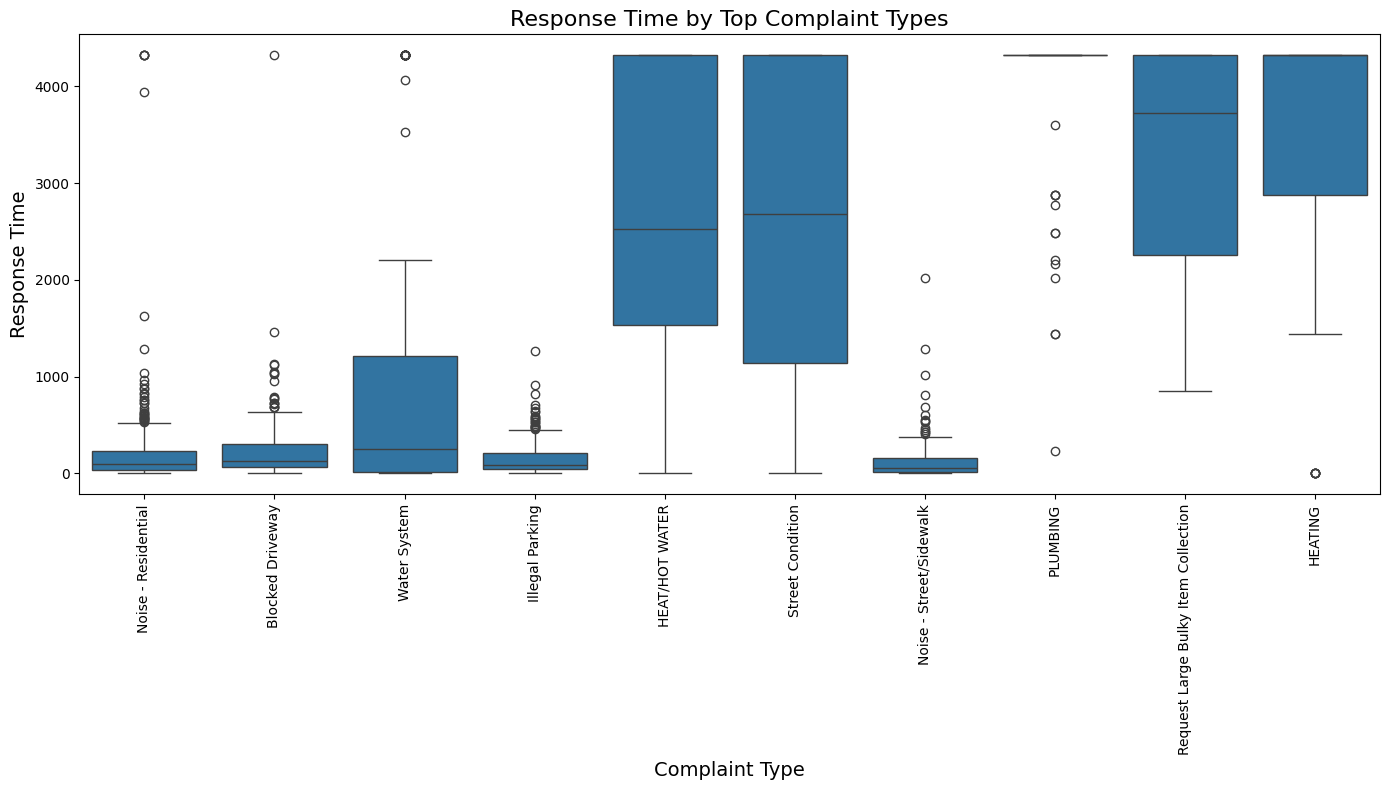

In [ ]:
#sample
# Ensure numeric columns are clean
df_sample['response_time'] = pd.to_numeric(df_sample['response_time'], errors='coerce')
# df_sample = df_sample.dropna(subset=['response_time'])  # Drop rows with NaN in response_time

# Remove outliers using IQR
Q1 = df_sample['response_time'].quantile(0.25)
Q3 = df_sample['response_time'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_sample = df_sample[(df_sample['response_time'] >= lower_bound) & (df_sample['response_time'] <= upper_bound)]

# Filter for the top N complaint types
top_complaints = df_sample['complaint_type'].value_counts().head(10).index
filtered_data = df_sample[df_sample['complaint_type'].isin(top_complaints)]

# Plot response_time by complaint_type
plt.figure(figsize=(14, 8))
sns.boxplot(x='complaint_type', y='response_time', data=filtered_data)
plt.xticks(rotation=90)
plt.title("Response Time by Top Complaint Types", fontsize=16)
plt.xlabel("Complaint Type", fontsize=14)
plt.ylabel("Response Time", fontsize=14)
plt.tight_layout()
plt.show()

## Response Time by Agency

This visualization compares response_time across different agencies.

A bar plot showing the average response_time for each agency.

<ipython-input-31-826b314e7c61>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=agency_response.index, y=agency_response.values, palette='Set2')


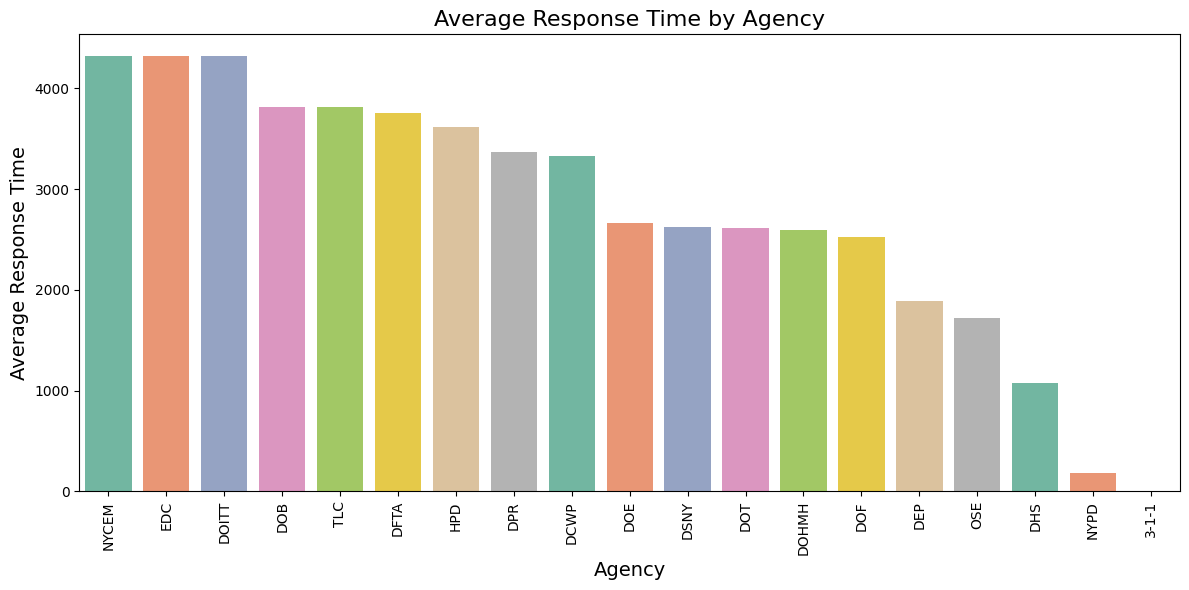

In [ ]:
#chunk
#Ensure numeric columns are clean
df_chunk['response_time'] = pd.to_numeric(df_chunk['response_time'], errors='coerce')
# df_sample = df_chunk.dropna(subset=['response_time'])  # Drop rows with NaN in response_time

# Step 3: Calculate average response time by agency
agency_response = (
    df_sample.groupby('agency')['response_time']
    .mean()  # Mean works directly in Pandas
    .sort_values(ascending=False)
)

# Step 4: Plot average response time by agency
plt.figure(figsize=(12, 6))
sns.barplot(x=agency_response.index, y=agency_response.values, palette='Set2')
plt.xticks(rotation=90)
plt.title("Average Response Time by Agency", fontsize=16)
plt.xlabel("Agency", fontsize=14)
plt.ylabel("Average Response Time", fontsize=14)
plt.tight_layout()
plt.show()

## Response Time Trends Over Time

This visualization tracks how response_time changes over time (e.g., monthly).

A line plot showing how the average response_time changes over months.

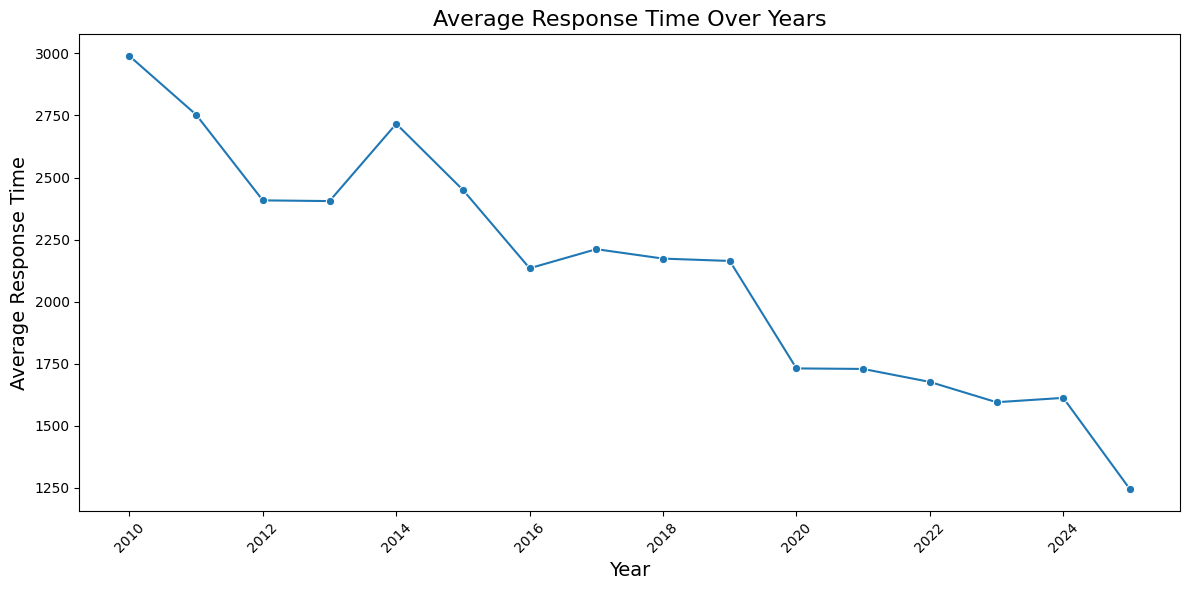

In [ ]:
#sample
# Step 1: Ensure 'created_date' is in datetime format
df_sample['created_date'] = pd.to_datetime(df_sample['created_date'], errors='coerce')

# Step 2: Extract the year from 'created_date'
df_sample['year'] = df_sample['created_date'].dt.year

# Step 3: Group by year and calculate average response time
yearly_response = df_sample.groupby('year')['response_time'].mean()

# Step 4: Plot response_time trends over years
plt.figure(figsize=(12, 6))
sns.lineplot(x=yearly_response.index, y=yearly_response.values, marker='o')
plt.xticks(rotation=45)
plt.title("Average Response Time Over Years", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Response Time", fontsize=14)
plt.tight_layout()
plt.show()

## Correlation Heatmap


This visualization shows the correlation between numeric features.

Numeric Columns: ['unique_key', 'incident_zip', 'bbl', 'latitude', 'longitude', 'response_time']
Non-Numeric Columns: ['created_date', 'agency', 'agency_name', 'complaint_type', 'descriptor', 'location_type', 'incident_address', 'street_name', 'cross_street_1', 'cross_street_2', 'address_type', 'city', 'status', 'resolution_action_updated_date', 'community_board', 'borough', 'open_data_channel_type', 'park_facility_name', 'park_borough', 'location']

Data Types After Conversion:
unique_key                     int64
created_date                  object
complaint_type                object
descriptor                    object
location_type                 object
                               ...  
park_borough_BROOKLYN           bool
park_borough_MANHATTAN          bool
park_borough_QUEENS             bool
park_borough_STATEN ISLAND      bool
park_borough_Unspecified        bool
Length: 65, dtype: object


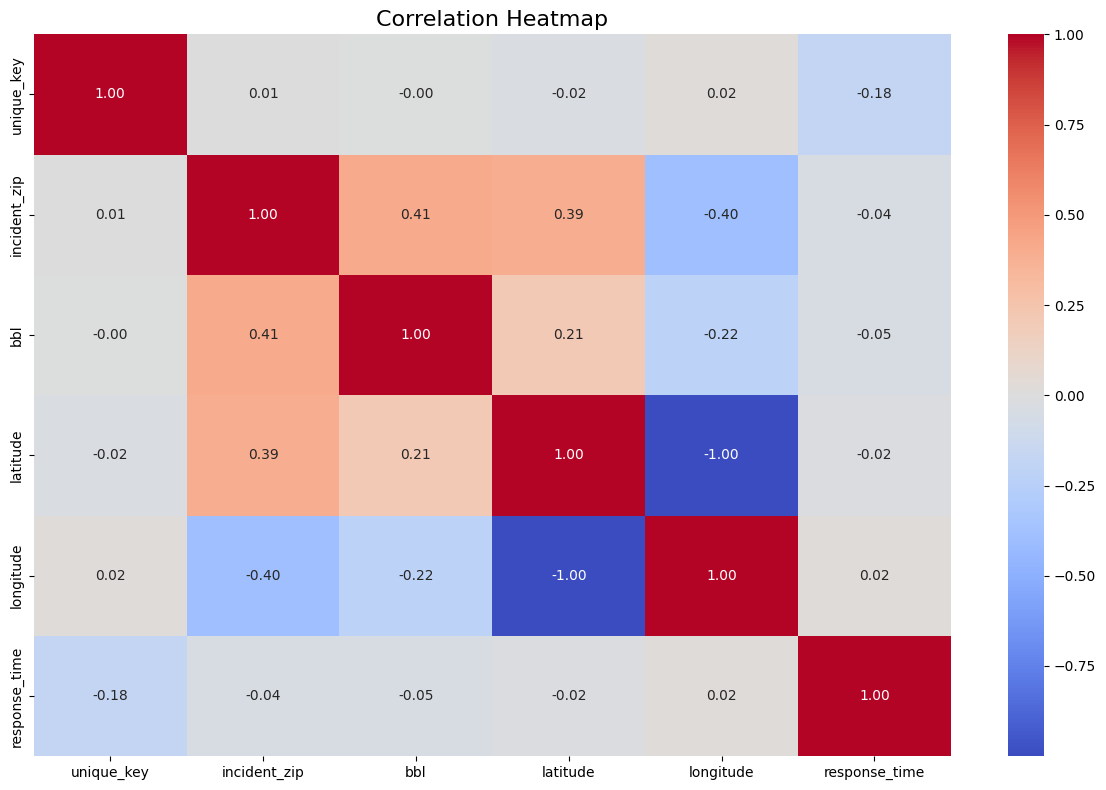

In [ ]:
#chunk
# Step 2: Identify numeric and non-numeric columns
numeric_columns = df_chunk.select_dtypes(include=['int64', 'float64']).columns
non_numeric_columns = df_chunk.select_dtypes(exclude=['int64', 'float64']).columns

print("Numeric Columns:", numeric_columns.tolist())
print("Non-Numeric Columns:", non_numeric_columns.tolist())

# Step 3: Convert numeric columns to numeric type
for col in numeric_columns:
    df_chunk[col] = pd.to_numeric(df_chunk[col], errors='coerce')

# Step 4: Handle missing values in numeric columns
df_chunk[numeric_columns] = df_chunk[numeric_columns].fillna(0)  # Replace NaN with 0

# Step 5: Drop unnecessary columns
columns_to_drop = ['incident_address', 'street_name', 'cross_street_1', 'cross_street_2']
df_chunk = df_chunk.drop(columns=columns_to_drop, errors='ignore')

# Update non-numeric columns
non_numeric_columns = df_chunk.select_dtypes(exclude=['int64', 'float64']).columns

# Step 6: Encode low-cardinality columns
low_cardinality_columns = [
    col for col in non_numeric_columns if df_chunk[col].nunique() < 50
]
df_encoded = pd.get_dummies(df_chunk, columns=low_cardinality_columns, drop_first=True)

# Step 7: Recheck data types
print("\nData Types After Conversion:")
print(df_encoded.dtypes)

# Step 8: Calculate the correlation matrix (if needed)
numeric_cols = df_encoded.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df_encoded[numeric_cols].corr()

# Step 9: Plot the heatmap (optional)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

## Agencies with the Most Complaints


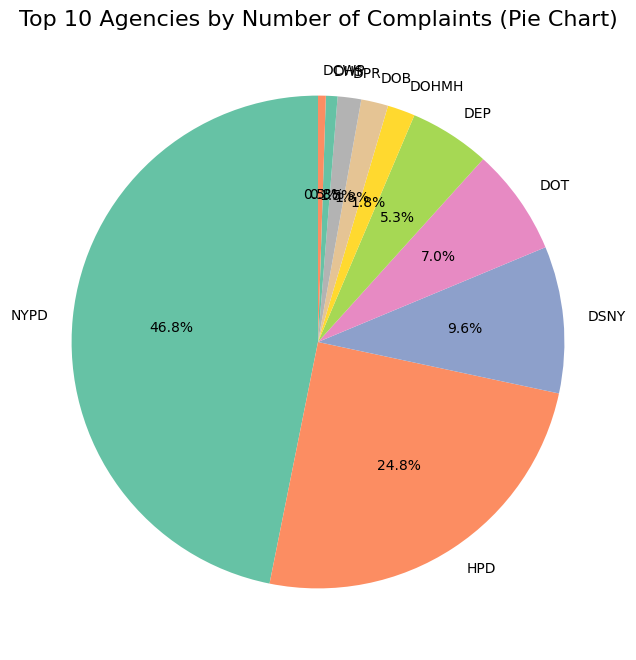

<ipython-input-34-5f4ae5d8dab9>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


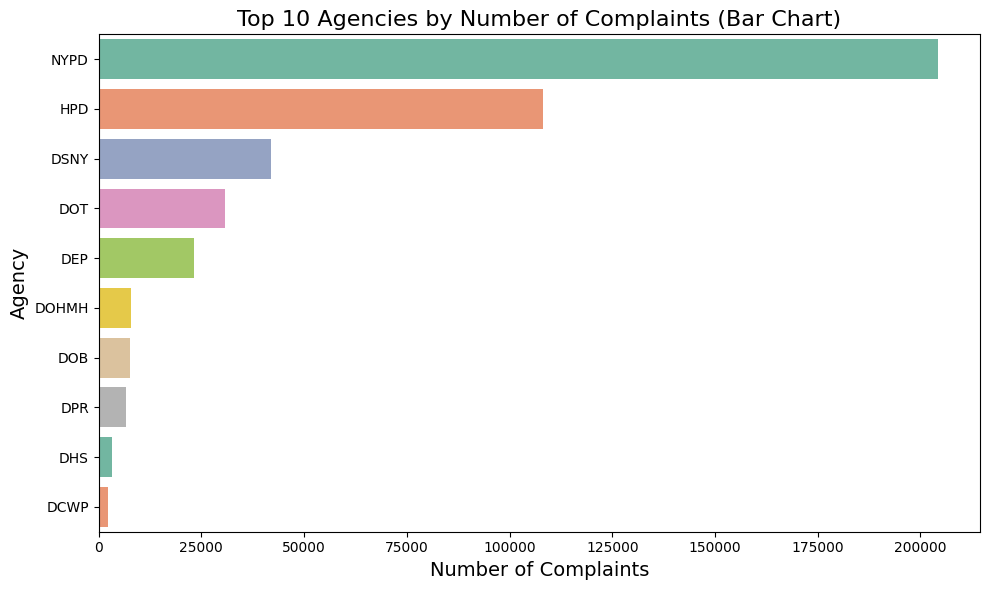

In [ ]:
#chunk
# Count complaints by agency and select the top 10 agencies
complaints_by_agency = df_chunk['agency'].value_counts().head(10)

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(
    complaints_by_agency,
    labels=complaints_by_agency.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('Set2')
)
plt.title('Top 10 Agencies by Number of Complaints (Pie Chart)', fontsize=16)
plt.show()

# Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x=complaints_by_agency.values,
    y=complaints_by_agency.index,
    palette='Set2'
)
plt.title('Top 10 Agencies by Number of Complaints (Bar Chart)', fontsize=16)
plt.xlabel('Number of Complaints', fontsize=14)
plt.ylabel('Agency', fontsize=14)
plt.tight_layout()
plt.show()

## Response Time by Complaint Type and City (Bar Plot)

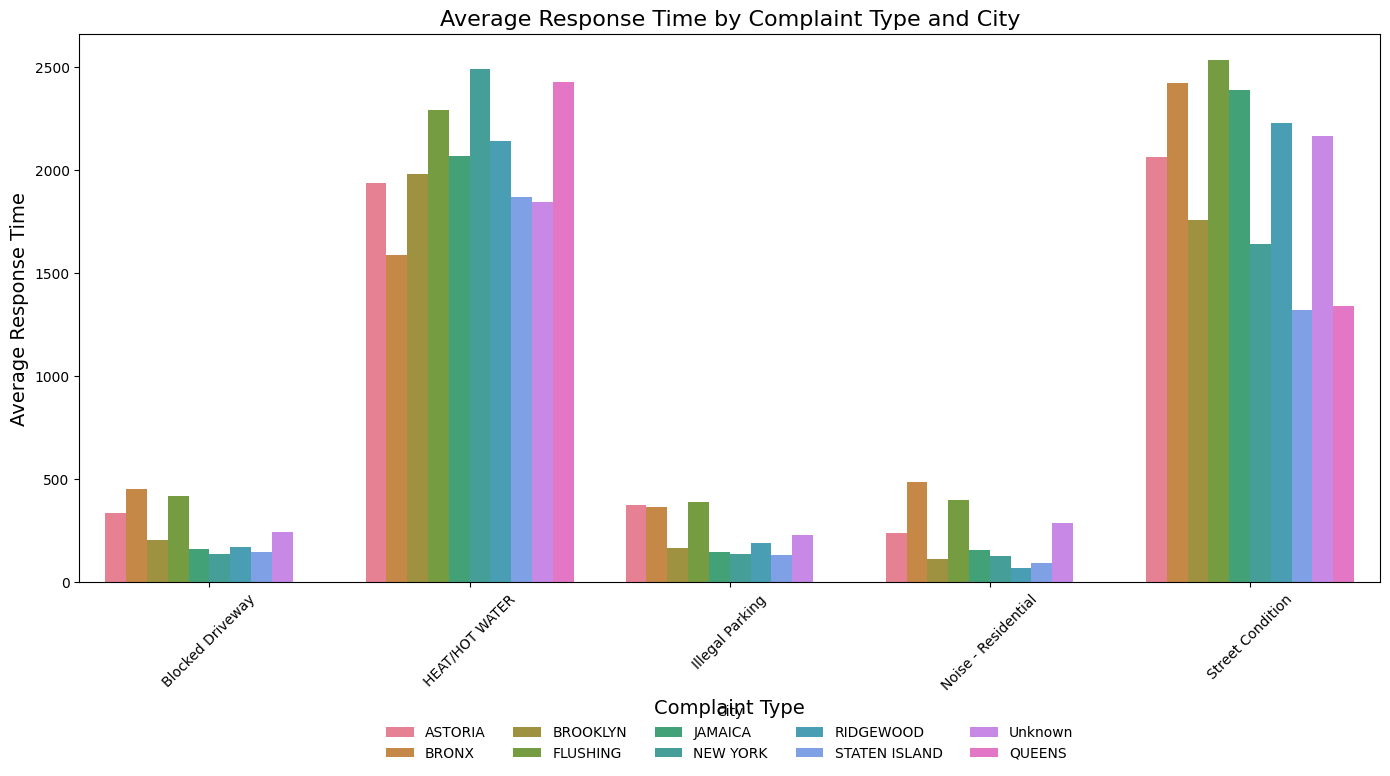

In [ ]:
#chunk
# Ensure numeric columns are clean
# Convert response_time to numeric, dropping invalid values
df_chunk['response_time'] = pd.to_numeric(df_chunk['response_time'], errors='coerce')
df_chunk = df_chunk.dropna(subset=['response_time', 'complaint_type', 'city'])

# Step 3: Aggregate the data
# Calculate the mean response time for each combination of complaint_type and city
grouped_data = df_chunk.groupby(['complaint_type', 'city'])['response_time'].mean().reset_index()

# Step 4: Filter for the top N complaint types (e.g., top 5 most frequent)
top_complaints = df_chunk['complaint_type'].value_counts().head(5).index
filtered_data = grouped_data[grouped_data['complaint_type'].isin(top_complaints)]

# Step 5: Filter for the top M cities (e.g., top 10 most frequent)
top_cities = df_chunk['city'].value_counts().head(10).index
filtered_data = filtered_data[filtered_data['city'].isin(top_cities)]

# Step 6: Use a larger color palette
custom_palette = sns.color_palette("husl", n_colors=len(filtered_data['city'].unique()))

# Step 7: Create the bar plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=filtered_data,
    x='complaint_type',
    y='response_time',
    hue='city',
    palette=custom_palette
)

# Add horizontal legend below the plot
plt.legend(
    title="City",
    loc='upper center',          # Place the legend below the plot
    bbox_to_anchor=(0.5, -0.2),  # Position the legend outside the plot
    ncol=5,                      # Number of columns in the legend
    frameon=False                # Optional: Remove the legend border
)

# Add plot labels and title
plt.title("Average Response Time by Complaint Type and City", fontsize=16)
plt.xlabel("Complaint Type", fontsize=14)
plt.ylabel("Average Response Time", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Top 10 complaint types

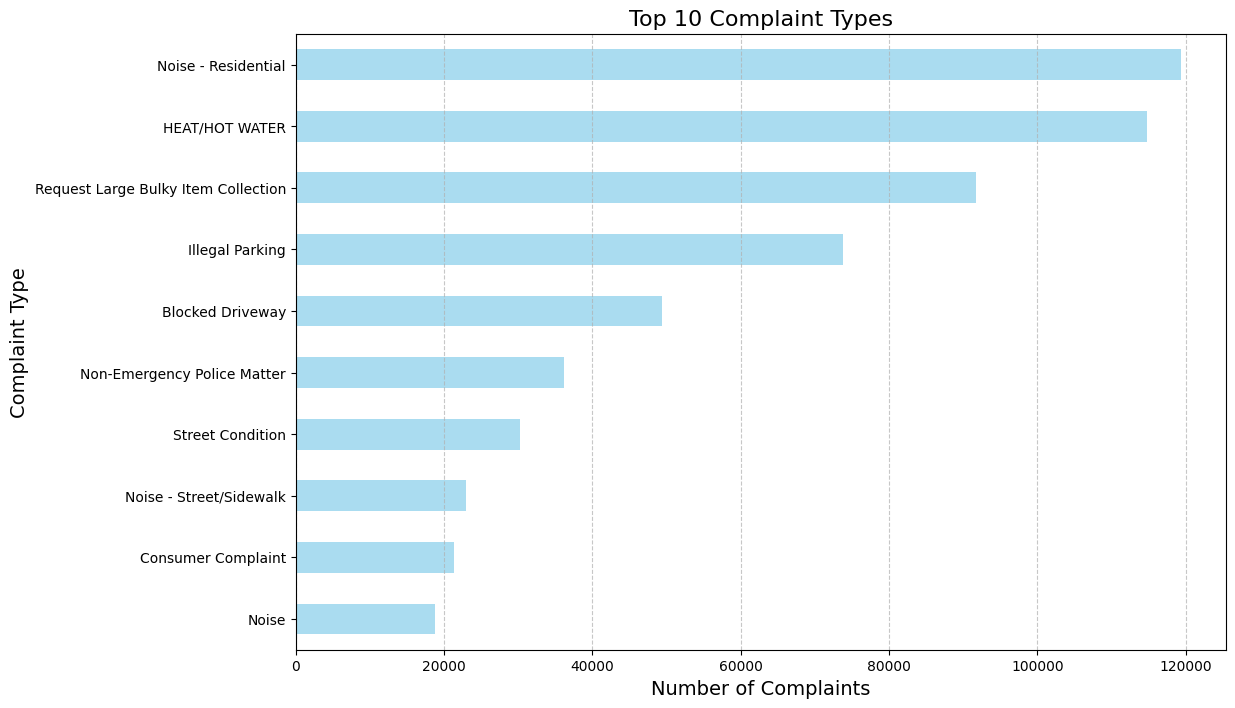

In [ ]:
#chunk another one
# Step 1: Load the data (if not already loaded)
chunk_file_2 = "/content/drive/MyDrive/Predict_response_time_project/dataset/data/chunk_16000000.csv"

df_chunk_2 = pd.read_csv(chunk_file_2)

# Step 2: Count the frequency of each complaint type
complaint_counts = df_chunk_2['complaint_type'].value_counts()

# Step 3: Select the top 10 complaint types
top_10_complaints = complaint_counts.head(10)

# Step 4: Create a horizontal bar plot
plt.figure(figsize=(12, 8))
top_10_complaints.plot(kind='barh', color='skyblue', alpha=0.7)
plt.title('Top 10 Complaint Types', fontsize=16)
plt.xlabel('Number of Complaints', fontsize=14)
plt.ylabel('Complaint Type', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the most frequent complaints at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# READING THE DATA

In [ ]:
#Reading the clean data

# Path to the directory containing all chunks
chunks_dir = "/content/drive/MyDrive/Predict_response_time_project/dataset/data/"

# Load all chunks lazily using Dask with specified dtypes
data = dd.read_csv(
    os.path.join(chunks_dir, "chunk_*.csv"),
    dtype=object)

#NOTE: Column types are in their right form

data.head()

,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,...,community_board,bbl,borough,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,response_time
0,64367473,2025-03-16 01:23:50,NYPD,New York City Police Department,Non-Emergency Police Matter,Other (complaint details),Street/Sidewalk,10011.0,200 8 AVENUE,8 AVENUE,...,04 MANHATTAN,1007700002.0,MANHATTAN,ONLINE,Unspecified,MANHATTAN,40.74355842464805,-73.99973655687788,"{'latitude': '40.74355842464805', 'longitude':...",12.816666666666666
1,64365300,2025-03-16 01:23:50,NYPD,New York City Police Department,Blocked Driveway,No Access,Street/Sidewalk,10465.0,1023 THROGMORTON AVENUE,THROGMORTON AVENUE,...,10 BRONX,2054580017.0,BRONX,PHONE,Unspecified,BRONX,40.83376804890142,-73.82113242149472,"{'latitude': '40.83376804890142', 'longitude':...",72.41666666666667
2,64362120,2025-03-16 01:23:39,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10128.0,405 EAST 92 STREET,EAST 92 STREET,...,08 MANHATTAN,1015730020.0,MANHATTAN,PHONE,Unspecified,MANHATTAN,40.78062469233427,-73.94640461344721,"{'latitude': '40.78062469233427', 'longitude':...",19.783333333333335
3,64367540,2025-03-16 01:22:31,NYPD,New York City Police Department,Noise - Residential,Loud Talking,Residential Building/House,10467.0,3250 PERRY AVENUE,PERRY AVENUE,...,07 BRONX,2033470001.0,BRONX,ONLINE,Unspecified,BRONX,40.87581786325145,-73.87624275879938,"{'latitude': '40.87581786325145', 'longitude':...",31.966666666666665
4,64362063,2025-03-16 01:22:20,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,10031.0,571 RIVERSIDE DRIVE,RIVERSIDE DRIVE,...,09 MANHATTAN,1020010001.0,MANHATTAN,ONLINE,Unspecified,MANHATTAN,40.820713607313536,-73.9583132733449,"{'latitude': '40.820713607313536', 'longitude'...",31.483333333333334


In [ ]:
# Check the data types of the columns
print("\nData Types After Loading:")
print(data.dtypes)


Data Types After Loading:
unique_key                        string[pyarrow]
created_date                      string[pyarrow]
agency                            string[pyarrow]
agency_name                       string[pyarrow]
complaint_type                    string[pyarrow]
descriptor                        string[pyarrow]
location_type                     string[pyarrow]
incident_zip                      string[pyarrow]
incident_address                  string[pyarrow]
street_name                       string[pyarrow]
cross_street_1                    string[pyarrow]
cross_street_2                    string[pyarrow]
address_type                      string[pyarrow]
city                              string[pyarrow]
status                            string[pyarrow]
resolution_action_updated_date    string[pyarrow]
community_board                   string[pyarrow]
bbl                               string[pyarrow]
borough                           string[pyarrow]
open_data_channel_type 

## Feature Engineering, Encoding, and Normalization Operations

In [ ]:
# Define paths
input_dir = "/content/drive/MyDrive/Predict_response_time_project/dataset/data/"
output_dir = "/content/drive/MyDrive/Predict_response_time_project/dataset/cleaned_data_2/"
scaler_dir = "/content/drive/MyDrive/Predict_response_time_project/dataset/scaler/"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)
os.makedirs(scaler_dir, exist_ok=True)

# Function to process a single chunk
def process_chunk(chunk, target_encoder=None, scaler=None):
    # Step 1: Convert date/time columns to datetime
    chunk['created_date'] = pd.to_datetime(chunk['created_date'], errors='coerce')
    chunk['resolution_action_updated_date'] = pd.to_datetime(chunk['resolution_action_updated_date'], errors='coerce')

    # Extract useful features from date/time columns
    chunk['created_year'] = chunk['created_date'].dt.year
    chunk['created_month'] = chunk['created_date'].dt.month
    chunk['created_day'] = chunk['created_date'].dt.day
    chunk['created_hour'] = chunk['created_date'].dt.hour

    # Drop original date/time columns
    chunk = chunk.drop(columns=['created_date', 'resolution_action_updated_date'])

    # Step 2: Convert numeric columns to numeric types
    numeric_cols = [
        'incident_zip', 'latitude', 'longitude', 'bbl', 'response_time',
        'created_year', 'created_month', 'created_day', 'created_hour'
    ]
    for col in numeric_cols:
        if col in chunk.columns:  # Ensure column exists before conversion
            chunk[col] = pd.to_numeric(chunk[col], errors='coerce')

    # Step 3: Encode categorical columns

    # a. One-Hot Encoding for low-cardinality columns
    low_cardinality_cols = ['agency', 'status', 'borough', 'open_data_channel_type']
    for col in low_cardinality_cols:
        if col in chunk.columns:  # Check if column exists
            chunk[col] = chunk[col].astype('category')
    chunk = pd.get_dummies(chunk, columns=low_cardinality_cols, drop_first=True)

    # b. Target Encoding for high-cardinality columns
    high_cardinality_cols = [
        'complaint_type', 'descriptor', 'incident_address', 'street_name',
        'city', 'community_board'  # Removed cross_street_1 and cross_street_2
    ]
    if target_encoder is None:
        # Initialize and fit TargetEncoder on the first chunk
        target_encoder = TargetEncoder()
        chunk[high_cardinality_cols] = target_encoder.fit_transform(
            chunk[high_cardinality_cols],
            chunk['response_time']
        )
    else:
        # Transform using the pre-fitted TargetEncoder
        chunk[high_cardinality_cols] = target_encoder.transform(
            chunk[high_cardinality_cols]
        )

    # c. Frequency Encoding for other categorical columns
    frequency_cols = ['park_facility_name', 'park_borough']
    for col in frequency_cols:
        if col in chunk.columns:  # Check if column exists
            freq_map = chunk[col].value_counts(normalize=True)
            chunk[col] = chunk[col].map(freq_map)

    # Step 4: Fill null values in encoded columns with 0
    # --> THIS IS THE NEW STEP ADDED TO HANDLE NULLS IN ENCODED COLUMNS
    encoded_columns = (
        list(chunk.filter(like='agency_').columns) +  # One-hot encoded columns
        list(chunk.filter(like='status_').columns) +
        list(chunk.filter(like='borough_').columns) +
        list(chunk.filter(like='open_data_channel_type_').columns) +
        high_cardinality_cols +  # Target-encoded columns
        frequency_cols  # Frequency-encoded columns
    )
    chunk[encoded_columns] = chunk[encoded_columns].fillna(0)

    # Step 5: Drop unused columns
    unused_columns = [
        'unique_key',  # Unique identifier, not useful for modeling
        'agency_name',  # Redundant after encoding `agency`
        'location_type',  # Unused string/object column
        'address_type',  # Unused string/object column
        'facility_type',  # Not relevant for response time prediction
        'resolution_description',  # Textual description, not useful for modeling
        'due_date',  # Likely redundant with created_date/response_time
        'taxi_pick_up_location',  # Not relevant for this use case
        'vehicle_type',  # Not relevant for this use case
        'x_coordinate_state_plane',  # Redundant with latitude/longitude
        'y_coordinate_state_plane',  # Redundant with latitude/longitude
        'cross_street_1',  # Redundant with latitude/longitude
        'cross_street_2',  # Redundant with latitude/longitude
        'intersection_street_1',  # Too specific, redundant with location
        'intersection_street_2',  # Too specific, redundant with location
        'landmark',  # Not relevant for response time prediction
        'location'  # Redundant with latitude/longitude
    ]
    # Drop unused columns if they exist
    chunk = chunk.drop(columns=[col for col in unused_columns if col in chunk.columns])

    # Step 6: Convert True/False to 1/0 for binary columns
    binary_columns = [
        col for col in chunk.columns if chunk[col].isin([True, False]).all()
    ]
    chunk[binary_columns] = chunk[binary_columns].astype(int)

    # Step 7: Normalize numeric columns
    numeric_cols_to_normalize = [
        'incident_zip', 'latitude', 'longitude', 'bbl', 'response_time',
        'created_year', 'created_month', 'created_day', 'created_hour',
        'complaint_type', 'descriptor', 'incident_address', 'street_name',
        'city', 'community_board', 'park_facility_name', 'park_borough'
    ]
    numeric_cols_to_normalize = [col for col in numeric_cols_to_normalize if col in chunk.columns]

    if scaler is None:
        # Initialize and fit the scaler on the first chunk
        scaler = StandardScaler()  # Use MinMaxScaler() if you prefer scaling to [0, 1]
        chunk[numeric_cols_to_normalize] = scaler.fit_transform(chunk[numeric_cols_to_normalize])

        # ADDED THIS DOWN : Save the mean and std for response_time

        response_time_index = numeric_cols_to_normalize.index('response_time')  # Find index of response_time
        response_time_mean = scaler.mean_[response_time_index]
        response_time_std = scaler.scale_[response_time_index]

        # Save these values for later use
        joblib.dump(response_time_mean, os.path.join(scaler_dir, "response_time_mean.pkl"))
        joblib.dump(response_time_std, os.path.join(scaler_dir, "response_time_std.pkl"))

        #ADDED THIS ABOVE

    else:
        # Transform using the pre-fitted scaler
        chunk[numeric_cols_to_normalize] = scaler.transform(chunk[numeric_cols_to_normalize])

    # Step 8: Fill all remaining null values with 0
    # --> THIS IS THE NEW STEP TO HANDLE ALL REMAINING NULL VALUES
    chunk = chunk.fillna(0)

    return chunk, target_encoder, scaler

# Process all chunks
target_encoder = None
scaler = None
for i, chunk_file in enumerate(sorted(os.listdir(input_dir))):
    if not chunk_file.endswith(".csv"):
        continue

    print(f"Processing chunk {i + 1}: {chunk_file}")
    chunk_path = os.path.join(input_dir, chunk_file)

    # Load the chunk
    chunk = pd.read_csv(chunk_path, dtype='object')

    # Process the chunk
    chunk, target_encoder, scaler = process_chunk(chunk, target_encoder, scaler)

    # Save the processed chunk
    output_path = os.path.join(output_dir, f"processed_{chunk_file}")
    chunk.to_csv(output_path, index=False)
    print(f"Saved processed chunk to {output_path}")

joblib.dump(scaler, "/content/drive/MyDrive/Predict_response_time_project/dataset/scaler/scaler.pkl")

print("All chunks processed and saved.")

Processing chunk 1: chunk_0.csv
Saved processed chunk to /content/drive/MyDrive/ColabNotebooks/dataset/cleaned_data_2/processed_chunk_0.csv
Processing chunk 2: chunk_1000000.csv
Saved processed chunk to /content/drive/MyDrive/ColabNotebooks/dataset/cleaned_data_2/processed_chunk_1000000.csv
Processing chunk 3: chunk_10000000.csv
Saved processed chunk to /content/drive/MyDrive/ColabNotebooks/dataset/cleaned_data_2/processed_chunk_10000000.csv
Processing chunk 4: chunk_11000000.csv
Saved processed chunk to /content/drive/MyDrive/ColabNotebooks/dataset/cleaned_data_2/processed_chunk_11000000.csv
Processing chunk 5: chunk_12000000.csv
Saved processed chunk to /content/drive/MyDrive/ColabNotebooks/dataset/cleaned_data_2/processed_chunk_12000000.csv
Processing chunk 6: chunk_13000000.csv
Saved processed chunk to /content/drive/MyDrive/ColabNotebooks/dataset/cleaned_data_2/processed_chunk_13000000.csv
Processing chunk 7: chunk_14000000.csv
Saved processed chunk to /content/drive/MyDrive/Colab

KeyboardInterrupt: 

In [ ]:
#Testing on a chunk

# Path to the directory containing all chunks
chunk_file = "/content/drive/MyDrive/Predict_response_time_project/dataset/cleaned_data/processed_chunk_0.csv"

df_chunk = pd.read_csv(chunk_file, low_memory=False)

#NOTE: Column types are in their right form

pd.set_option('display.max_columns', None)  # Show all columns
print(df_chunk.head())

   complaint_type  descriptor  incident_zip  incident_address  street_name  \
0       -0.919057   -0.917321     -0.607094         -0.333583     0.103722   
1       -0.860267   -0.842587     -0.220951         -0.263956     0.056738   
2       -0.843971   -0.814264     -0.507581         -1.807411    -0.873114   
3       -0.843971   -0.928031     -0.219250          0.598262     0.284550   
4       -0.843971   -0.814264     -0.590083         -2.257909     0.349546   

       city  community_board       bbl  park_facility_name  park_borough  \
0  1.016282         0.023943 -1.046446            0.050132     -0.812757   
1  0.766119         0.238272 -0.277809            0.050132     -0.300053   
2  1.016282         0.580974 -1.040551            0.050132     -0.812757   
3  0.766119         0.592780 -0.293309            0.050132     -0.300053   
4  1.016282         1.510669 -1.037408            0.050132     -0.812757   

   latitude  longitude  response_time  created_year  created_month  \
0  0

In [ ]:
# Path to the directory containing all chunks
chunk_file_2 = "/content/drive/MyDrive/Predict_response_time_project/dataset/cleaned_data/processed_chunk_0.csv"

# Load the chunk into a Pandas DataFrame
df_chunk = pd.read_csv(chunk_file_2, low_memory=False)

# Define the target variable (assuming 'response_time' is the target)
y = df_chunk['response_time']

# Check for missing values in the target variable and handle them if necessary
if y.isnull().any():
    print("Warning: Missing values found in the target variable. Filling with 0.")
    y = y.fillna(0)

# Calculate the range of the target variable
target_range = y.max() - y.min()
print(f"Target Variable Range: {target_range}")

# Calculate 10% and 15% of the range
threshold_10_percent = 0.10 * target_range
threshold_15_percent = 0.15 * target_range

print(f"10% of Range: {threshold_10_percent}")
print(f"15% of Range: {threshold_15_percent}")

Target Variable Range: 2.7365921775347033
10% of Range: 0.27365921775347035
15% of Range: 0.41048882663020547


# READING THE DATA FOR MODEL

In [ ]:
#Reading the clean data

# Path to the directory containing all chunks
chunks_dir = "/content/drive/MyDrive/Predict_response_time_project/dataset/cleaned_data/"

# Final dataset, Load all chunks lazily using Dask with specified dtypes
fd = dd.read_csv(os.path.join(chunks_dir, "processed_chunk_*.csv"))

#NOTE: Column types are: OBJECT/STRING in this read operation so we can take sample of our data without facing any issues
pd.set_option('display.max_columns', None)  # Show all columns
print(fd.head())

   complaint_type  descriptor  incident_zip  incident_address  street_name  \
0       -0.919057   -0.917321     -0.607094         -0.333583     0.103722   
1       -0.860267   -0.842587     -0.220951         -0.263956     0.056738   
2       -0.843971   -0.814264     -0.507581         -1.807411    -0.873114   
3       -0.843971   -0.928031     -0.219250          0.598262     0.284550   
4       -0.843971   -0.814264     -0.590083         -2.257909     0.349546   

       city  community_board       bbl  park_facility_name  park_borough  \
0  1.016282         0.023943 -1.046446            0.050132     -0.812757   
1  0.766119         0.238272 -0.277809            0.050132     -0.300053   
2  1.016282         0.580974 -1.040551            0.050132     -0.812757   
3  0.766119         0.592780 -0.293309            0.050132     -0.300053   
4  1.016282         1.510669 -1.037408            0.050132     -0.812757   

   latitude  longitude  response_time  created_year  created_month  \
0  0

## Sample my data for train-test splits and model

In [ ]:
# Step 1: Define paths
cleaned_chunks_dir = "/content/drive/MyDrive/Predict_response_time_project/dataset/cleaned_data_2/"
output_file = "/content/drive/MyDrive/Predict_response_time_project/dataset/sample_2.csv"

# Step 2: Define the number of rows to sample from each chunk
rows_per_chunk = 105_000

# Step 3: List all chunk files
chunk_files = sorted([f for f in os.listdir(cleaned_chunks_dir) if f.startswith("processed_chunk_") and f.endswith(".csv")])

# Step 4: Initialize an empty list to store sampled chunks
sampled_chunks = []

# Step 5: Sample rows from each chunk
for chunk_file in chunk_files:
    print(f"Processing {chunk_file}...")
    try:
        # Read the chunk
        df_chunk = pd.read_csv(os.path.join(cleaned_chunks_dir, chunk_file), low_memory=False)

        # Randomly sample rows
        df_sampled = df_chunk.sample(n=rows_per_chunk, random_state=42)

        # Append the sampled chunk to the list
        sampled_chunks.append(df_sampled)

        print(f"Sampled {len(df_sampled)} rows from {chunk_file}")
    except Exception as e:
        print(f"Error processing {chunk_file}: {e}")

# Step 6: Combine all sampled chunks into a single DataFrame
print("Combining all sampled chunks...")
df_sampled_combined = pd.concat(sampled_chunks, ignore_index=True)

# Step 7: Save the combined sample to a single CSV file
print(f"Saving combined sample to {output_file}...")
df_sampled_combined.to_csv(output_file, index=False)

print(f"Total sampled rows: {len(df_sampled_combined)}")

Processing processed_chunk_0.csv...
Sampled 105000 rows from processed_chunk_0.csv
Processing processed_chunk_1000000.csv...
Sampled 105000 rows from processed_chunk_1000000.csv
Processing processed_chunk_10000000.csv...
Sampled 105000 rows from processed_chunk_10000000.csv
Processing processed_chunk_11000000.csv...
Sampled 105000 rows from processed_chunk_11000000.csv
Processing processed_chunk_12000000.csv...
Sampled 105000 rows from processed_chunk_12000000.csv
Processing processed_chunk_13000000.csv...
Sampled 105000 rows from processed_chunk_13000000.csv
Processing processed_chunk_14000000.csv...
Sampled 105000 rows from processed_chunk_14000000.csv
Processing processed_chunk_1500000.csv...
Sampled 105000 rows from processed_chunk_1500000.csv
Processing processed_chunk_15000000.csv...
Sampled 105000 rows from processed_chunk_15000000.csv
Processing processed_chunk_16000000.csv...
Sampled 105000 rows from processed_chunk_16000000.csv
Processing processed_chunk_17000000.csv...
Sampl

# Train-test split

In [ ]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("DebugVectorAssembler") \
    .getOrCreate()

# Load the sampled data
sample_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/sample_2.csv"
df_sample = spark.read.csv(sample_path, header=True, inferSchema=True)

# Inspect the schema
print("Schema of the input DataFrame:")
df_sample.printSchema()

# List of feature columns (exclude the target column 'response_time')
feature_columns = [col_name for col_name in df_sample.columns if col_name != "response_time"]

# Check for null values BEFORE filling
null_counts_before = {col_name: df_sample.filter(col(col_name).isNull()).count() for col_name in feature_columns}
print("Null counts in feature columns BEFORE filling nulls:")
print(null_counts_before)

# Handle null values (fill them with 0)
df_sample = df_sample.na.fill(0)

# Check for null values AFTER filling
null_counts_after = {col_name: df_sample.filter(col(col_name).isNull()).count() for col_name in feature_columns}
print("Null counts in feature columns AFTER filling nulls with 0:")
print(null_counts_after)

# Ensure all feature columns are numeric
for col_name in feature_columns:
    df_sample = df_sample.withColumn(col_name, col(col_name).cast("double"))

# Save the processed dataset to a new file (sample_3.csv)
output_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/sample_3.csv"
df_sample.write.csv(output_path, header=True, mode="overwrite")
print(f"Processed dataset saved successfully to {output_path}")

# Test the VectorAssembler with a small subset of the data
test_df = df_sample.limit(10)
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

try:
    test_output = assembler.transform(test_df)
    print("VectorAssembler output:")
    test_output.show()
except Exception as e:
    print("Error during VectorAssembler transformation:")
    print(e)

# Stop Spark Session
spark.stop()

Schema of the input DataFrame:
root
 |-- complaint_type: double (nullable = true)
 |-- descriptor: double (nullable = true)
 |-- incident_zip: double (nullable = true)
 |-- incident_address: double (nullable = true)
 |-- street_name: double (nullable = true)
 |-- city: double (nullable = true)
 |-- community_board: double (nullable = true)
 |-- bbl: double (nullable = true)
 |-- park_facility_name: double (nullable = true)
 |-- park_borough: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- response_time: double (nullable = true)
 |-- created_year: double (nullable = true)
 |-- created_month: double (nullable = true)
 |-- created_day: double (nullable = true)
 |-- created_hour: double (nullable = true)
 |-- agency_DEP: integer (nullable = true)
 |-- agency_DHS: double (nullable = true)
 |-- agency_DOB: integer (nullable = true)
 |-- agency_DOE: integer (nullable = true)
 |-- agency_DOHMH: integer (nullable = true)
 |-- agency

### Check the range of response time

In [ ]:
response_time_range = df_sample['response_time'].min(), df_sample['response_time'].max()
print(f"Range of response_time: {response_time_range}")

Range of response_time: (-0.820612759908707, 1.915979417625996)


# Gradient Boosting Regressor

In [ ]:
df_sample = pd.read_csv("/content/drive/MyDrive/Predict_response_time_project/dataset/for_model/for_m.csv")

# # Path to the directory containing the CSV files
# directory_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/sample_3.csv"

# # Get a list of all CSV files in the directory
# csv_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(".csv")]

# # Read and concatenate all CSV files into a single DataFrame
# df_sample = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Split into train and test sets
train_data, test_data = train_test_split(df_sample, test_size=0.2, random_state=42)
# print(f"Training set size: {train_data.shape[0]} rows")
# print(f"Testing set size: {test_data.shape[0]} rows")

# List of feature columns (exclude the target column 'response_time')
feature_columns = [col for col in df_sample.columns if col != "response_time"]

# Separate features and target
X_train = train_data[feature_columns]
y_train = train_data["response_time"]
X_test = test_data[feature_columns]
y_test = test_data["response_time"]

# Check for missing values
missing_values = X_train.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

# Handle missing values using an imputer
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Train a Gradient Boosted Trees model
gbt = GradientBoostingRegressor(random_state=42)
gbt.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gbt.predict(X_test)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)  # MAE
r2 = r2_score(y_test, y_pred)  # R² Score

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Save the trained Gradient Boosting Regressor model to the specified path
model_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/GradientBoostingRegressor.pkl"
joblib.dump(gbt, model_path)

print(f"Model saved successfully to {model_path}")

Missing values in each column:
Series([], dtype: int64)
Root Mean Squared Error (RMSE): 0.68
Mean Absolute Error (MAE): 0.46
R² Score: 0.69
Model saved successfully to /content/drive/MyDrive/ColabNotebooks/dataset/GradientBoostingRegressor.pkl


# Random Forest Regressor

In [ ]:
df_sample = pd.read_csv("/content/drive/MyDrive/Predict_response_time_project/dataset/for_model/for_m.csv")

# # Path to the directory containing the CSV files
# directory_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/sample_3.csv"

# # Get a list of all CSV files in the directory
# csv_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(".csv")]

# # Read and concatenate all CSV files into a single DataFrame
# df_sample = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Split into train and test sets
train_data, test_data = train_test_split(df_sample, test_size=0.2, random_state=42)
# print(f"Training set size: {train_data.shape[0]} rows")
# print(f"Testing set size: {test_data.shape[0]} rows")

# List of feature columns (exclude the target column 'response_time')
feature_columns = [col for col in df_sample.columns if col != "response_time"]

# Separate features and target
X_train = train_data[feature_columns]
y_train = train_data["response_time"]
X_test = test_data[feature_columns]
y_test = test_data["response_time"]

# Handle missing values using an imputer
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

rf = RandomForestRegressor(random_state=42, n_estimators=50, max_depth=10, n_jobs=-1)     # Limit tree depth to prevent overfitting and save memory  # Use Random Forest
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, y_pred))  # Compute RMSE manually
mae = mean_absolute_error(y_test, y_pred)  # MAE
r2 = r2_score(y_test, y_pred)  # R² Score

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Save the trained Random Forest model to the specified path
model_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/RandomForestRegressor.pkl"
joblib.dump(rf, model_path)

print(f"Model saved successfully to {model_path}")

Root Mean Squared Error (RMSE): 0.65
Mean Absolute Error (MAE): 0.42
R² Score: 0.71
Model saved successfully to /content/drive/MyDrive/ColabNotebooks/dataset/RandomForestRegressor.pkl


# Linear Regression

In [ ]:
df_sample = pd.read_csv("/content/drive/MyDrive/Predict_response_time_project/dataset/for_model/for_m.csv")

# # Path to the directory containing the CSV files
# directory_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/sample_3.csv"

# # Get a list of all CSV files in the directory
# csv_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(".csv")]

# # Read and concatenate all CSV files into a single DataFrame
# df_sample = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Split into train and test sets
train_data, test_data = train_test_split(df_sample, test_size=0.2, random_state=42)
# print(f"Training set size: {train_data.shape[0]} rows")
# print(f"Testing set size: {test_data.shape[0]} rows")

# List of feature columns (exclude the target column 'response_time')
feature_columns = [col for col in df_sample.columns if col != "response_time"]

# Separate features and target
X_train = train_data[feature_columns]
y_train = train_data["response_time"]
X_test = test_data[feature_columns]
y_test = test_data["response_time"]

# Handle missing values using an imputer
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Train a Linear Regression model
lr = LinearRegression()  # Use Linear Regression
lr.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr.predict(X_test)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, y_pred))  # Compute RMSE manually
mae = mean_absolute_error(y_test, y_pred)  # MAE
r2 = r2_score(y_test, y_pred)  # R² Score

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Save the trained Random Forest model to the specified path
model_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/LinearRegression.pkl"
joblib.dump(lr, model_path)

print(f"Model saved successfully to {model_path}")

Root Mean Squared Error (RMSE): 0.73
Mean Absolute Error (MAE): 0.53
R² Score: 0.63
Model saved successfully to /content/drive/MyDrive/ColabNotebooks/dataset/LinearRegression.pkl


# XG Boost

In [ ]:
df_sample = pd.read_csv("/content/drive/MyDrive/Predict_response_time_project/dataset/for_model/for_m.csv")

# # Path to the directory containing the CSV files
# directory_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/sample_3.csv"

# # Get a list of all CSV files in the directory
# csv_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(".csv")]

# # Read and concatenate all CSV files into a single DataFrame
# df_sample = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Split into train and test sets
train_data, test_data = train_test_split(df_sample, test_size=0.2, random_state=42)

# List of feature columns (exclude the target column 'response_time')
feature_columns = [col for col in df_sample.columns if col != "response_time"]

# Separate features and target
X_train = train_data[feature_columns]
y_train = train_data["response_time"]
X_test = test_data[feature_columns]
y_test = test_data["response_time"]

# Handle missing values using an imputer
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Train an XGBoost model
xgb = XGBRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
xgb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb.predict(X_test)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)  # MAE
r2 = r2_score(y_test, y_pred)  # R² Score

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Save the trained XGBoost model to the specified path
model_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/XGBoostRegressor.pkl"
joblib.dump(xgb, model_path)

print(f"Model saved successfully to {model_path}")

Root Mean Squared Error (RMSE): 0.63
Mean Absolute Error (MAE): 0.42
R² Score: 0.73
Model saved successfully to /content/drive/MyDrive/ColabNotebooks/dataset/XGBoostRegressor.pkl


# LightGBM Regressor


In [ ]:
df_sample = pd.read_csv("/content/drive/MyDrive/Predict_response_time_project/dataset/for_model/for_m.csv")

# # Path to the directory containing the CSV files
# directory_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/sample_3.csv"

# # Get a list of all CSV files in the directory
# csv_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(".csv")]

# # Read and concatenate all CSV files into a single DataFrame
# df_sample = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Split into train and test sets
train_data, test_data = train_test_split(df_sample, test_size=0.2, random_state=42)

# List of feature columns (exclude the target column 'response_time')
feature_columns = [col for col in df_sample.columns if col != "response_time"]

# Separate features and target
X_train = train_data[feature_columns]
y_train = train_data["response_time"]
X_test = test_data[feature_columns]
y_test = test_data["response_time"]

# Handle missing values using an imputer
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Train a LightGBM model
lgbm = LGBMRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
lgbm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lgbm.predict(X_test)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)  # MAE
r2 = r2_score(y_test, y_pred)  # R² Score

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Save the trained LightGBM model to the specified path
model_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/LightGBMRegressor.pkl"
joblib.dump(lgbm, model_path)

print(f"Model saved successfully to {model_path}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.947691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 3948000, number of used features: 45
[LightGBM] [Info] Start training from score 0.468376


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Root Mean Squared Error (RMSE): 0.63
Mean Absolute Error (MAE): 0.42
R² Score: 0.73
Model saved successfully to /content/drive/MyDrive/ColabNotebooks/dataset/LightGBMRegressor.pkl


# Ridge Regression


In [ ]:
df_sample = pd.read_csv("/content/drive/MyDrive/Predict_response_time_project/dataset/for_model/for_m.csv")

# # Path to the directory containing the CSV files
# directory_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/sample_3.csv"

# # Get a list of all CSV files in the directory
# csv_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(".csv")]

# # Read and concatenate all CSV files into a single DataFrame
# df_sample = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Split into train and test sets
train_data, test_data = train_test_split(df_sample, test_size=0.2, random_state=42)

# List of feature columns (exclude the target column 'response_time')
feature_columns = [col for col in df_sample.columns if col != "response_time"]

# Separate features and target
X_train = train_data[feature_columns]
y_train = train_data["response_time"]
X_test = test_data[feature_columns]
y_test = test_data["response_time"]

# Handle missing values using an imputer
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Train a Ridge Regression model
ridge = Ridge(alpha=1.0)  # alpha controls regularization strength
ridge.fit(X_train, y_train)

# Make predictions on the test data
y_pred = ridge.predict(X_test)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)  # MAE
r2 = r2_score(y_test, y_pred)  # R² Score

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Save the trained Ridge Regression model to the specified path
model_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/RidgeRegressor.pkl"
joblib.dump(ridge, model_path)

print(f"Model saved successfully to {model_path}")

Root Mean Squared Error (RMSE): 0.73
Mean Absolute Error (MAE): 0.53
R² Score: 0.63
Model saved successfully to /content/drive/MyDrive/ColabNotebooks/dataset/RidgeRegressor.pkl


# Lasso Regression


In [ ]:
# Path to the directory containing the CSV files
# directory_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/sample_3.csv"
# directory_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/for_model/for_m.csv"
df_sample = pd.read_csv("/content/drive/MyDrive/Predict_response_time_project/dataset/for_model/for_m.csv")

# # Get a list of all CSV files in the directory
# csv_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith(".csv")]

# # Read and concatenate all CSV files into a single DataFrame
# df_sample = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Split into train and test sets
train_data, test_data = train_test_split(df_sample, test_size=0.2, random_state=42)

# List of feature columns (exclude the target column 'response_time')
feature_columns = [col for col in df_sample.columns if col != "response_time"]

# Separate features and target
X_train = train_data[feature_columns]
y_train = train_data["response_time"]
X_test = test_data[feature_columns]
y_test = test_data["response_time"]

# Handle missing values using an imputer
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Train a Lasso Regression model
lasso = Lasso(alpha=0.1)  # alpha controls regularization strength
lasso.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lasso.predict(X_test)

# Evaluate the model
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)  # MAE
r2 = r2_score(y_test, y_pred)  # R² Score

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Save the trained Lasso Regression model to the specified path
model_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/LassoRegressor.pkl"
joblib.dump(lasso, model_path)

print(f"Model saved successfully to {model_path}")

Root Mean Squared Error (RMSE): 0.80
Mean Absolute Error (MAE): 0.63
R² Score: 0.56
Model saved successfully to /content/drive/MyDrive/ColabNotebooks/dataset/LassoRegressor.pkl


# Test my model on new data and reverse target column 'response_time' to its original values (1)

In [ ]:
# Step 1: Load the trained model
model = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/LightGBMRegressor.pkl")  # Load the trained model

# Step 2: Prepare New Data
# Example of new data (replace this with your actual new data)
new_data = pd.read_csv("/content/drive/MyDrive/Predict_response_time_projects/dataset/cleaned_data_2/processed_chunk_39000000.csv")

# Handle missing values
new_data = new_data.fillna(0)

# Drop the target column (if present)
new_data = new_data.drop(columns=['response_time'], errors='ignore')

# Ensure the order of columns matches the training data
expected_columns = [
    'complaint_type', 'descriptor', 'incident_zip', 'city',
    'community_board', 'park_facility_name', 'park_borough', 'latitude',
    'longitude', 'incident_address', 'street_name', 'bbl', 'created_year',
    'created_month', 'created_day', 'created_hour', 'agency_DEP',
    'agency_DFTA', 'agency_DHS', 'agency_DOB', 'agency_DOE', 'agency_DOF',
    'agency_DOHMH', 'agency_DOITT', 'agency_DOT', 'agency_DPR',
    'agency_DSNY', 'agency_HPD', 'agency_NYCEM', 'agency_NYPD',
    'agency_TLC', 'status_Closed', 'status_Closed - Testing', 'status_Open',
    'status_Pending', 'status_Started', 'status_Unspecified',
    'borough_BROOKLYN', 'borough_MANHATTAN', 'borough_QUEENS',
    'borough_STATEN ISLAND', 'borough_Unknown', 'borough_Unspecified',
    'open_data_channel_type_OTHER', 'open_data_channel_type_PHONE',
    'open_data_channel_type_UNKNOWN'
]

# Reorder columns to match the training data
missing_columns = set(expected_columns) - set(new_data.columns)
for col in missing_columns:
    new_data[col] = 0  # Add missing columns with default value 0
new_data = new_data[expected_columns]

# Step 3: Make Predictions
predicted_response_time = model.predict(new_data)

# Step 4: Reverse Normalization
# Load the saved normalization parameters for response_time
response_time_mean = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/scaler/response_time_mean.pkl")
response_time_std = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/scaler/response_time_std.pkl")

# Reverse normalization for StandardScaler
predicted_response_time_original = predicted_response_time * response_time_std + response_time_mean

# If you used MinMaxScaler instead, use the following formula:
# response_time_min = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/scaler/response_time_min.pkl")
# response_time_max = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/scaler/response_time_max.pkl")
# predicted_response_time_original = predicted_response_time * (response_time_max - response_time_min) + response_time_min

# Step 5: Display the Results
np.set_printoptions(threshold=np.inf)  # Disable truncation of arrays
# print("Predicted Response Time (Normalized Scale):", predicted_response_time)
print("Predicted Response Time (Original Scale in Minutes):", predicted_response_time_original)

Streaming output truncated to the last 5000 lines.
  2.97745821e+03  2.97417966e+03  2.66965591e+03  3.03299522e+03
  7.47570878e+02  3.84854450e+03  2.98965449e+03  2.70375663e+03
  2.66965591e+03  2.05927637e+03  2.99985473e+03  1.12380560e+03
  3.13272550e+03  3.34431033e+03  3.76592261e+03  6.93322030e+02
  1.98885280e+03  2.84211326e+03  2.97417966e+03  2.68887229e+03
  2.68887229e+03  2.68887229e+03  3.63750439e+03  2.75699713e+03
  3.58337277e+03  3.24016009e+03  3.51637870e+03  2.78721935e+03
  3.13272550e+03  2.84211326e+03  3.46666264e+03  3.19868711e+03
  2.29243566e+03  2.97417966e+03  3.13119485e+03  2.92508380e+03
  3.26509937e+03  9.48172232e+02  3.50669809e+03  2.92508380e+03
  3.07325306e+03  2.97745821e+03  3.33051222e+03  9.16269964e+02
  1.89118284e+03  3.77956279e+03  2.91752237e+03  2.66965591e+03
  1.20075452e+03  3.33051222e+03  2.26030141e+03  2.98965449e+03
  2.97417966e+03  3.33676609e+03  1.78100147e+03  3.13272550e+03
  3.53027801e+03  3.33051222e+03  3.072

In [ ]:
# Step 1: Load the trained model
model = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/LightGBMRegressor.pkl")  # Load the trained model

# Step 2: Prepare New Data
# Example of new data (replace this with your actual new data)
new_data = pd.read_csv("/content/drive/MyDrive/Predict_response_time_project/dataset/cleaned_data_2/processed_chunk_6500000.csv")

# Handle missing values
new_data = new_data.fillna(0)

# Drop the target column (if present)
new_data = new_data.drop(columns=['response_time'], errors='ignore')

# Ensure the order of columns matches the training data
expected_columns = [
    'complaint_type', 'descriptor', 'incident_zip', 'city',
    'community_board', 'park_facility_name', 'park_borough', 'latitude',
    'longitude', 'incident_address', 'street_name', 'bbl', 'created_year',
    'created_month', 'created_day', 'created_hour', 'agency_DEP',
    'agency_DFTA', 'agency_DHS', 'agency_DOB', 'agency_DOE', 'agency_DOF',
    'agency_DOHMH', 'agency_DOITT', 'agency_DOT', 'agency_DPR',
    'agency_DSNY', 'agency_HPD', 'agency_NYCEM', 'agency_NYPD',
    'agency_TLC', 'status_Closed', 'status_Closed - Testing', 'status_Open',
    'status_Pending', 'status_Started', 'status_Unspecified',
    'borough_BROOKLYN', 'borough_MANHATTAN', 'borough_QUEENS',
    'borough_STATEN ISLAND', 'borough_Unknown', 'borough_Unspecified',
    'open_data_channel_type_OTHER', 'open_data_channel_type_PHONE',
    'open_data_channel_type_UNKNOWN'
]

# Reorder columns to match the training data
missing_columns = set(expected_columns) - set(new_data.columns)
for col in missing_columns:
    new_data[col] = 0  # Add missing columns with default value 0
new_data = new_data[expected_columns]

# Step 3: Make Predictions
predicted_response_time = model.predict(new_data)

# Step 4: Reverse Normalization
# Load the saved normalization parameters for response_time
response_time_mean = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/scaler/response_time_mean.pkl")
response_time_std = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/scaler/response_time_std.pkl")

# Reverse normalization for StandardScaler
predicted_response_time_original = predicted_response_time * response_time_std + response_time_mean

# If you used MinMaxScaler instead, use the following formula:
# response_time_min = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/scaler/response_time_min.pkl")
# response_time_max = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/scaler/response_time_max.pkl")
# predicted_response_time_original = predicted_response_time * (response_time_max - response_time_min) + response_time_min

# Step 5: Display the Results
# Format the output to avoid scientific notation
np.set_printoptions(suppress=True, precision=2)  # Suppress scientific notation and round to 2 decimal places
print("Predicted Response Time (Original Scale in Minutes):", predicted_response_time_original)

Predicted Response Time (Original Scale in Minutes): [ 520.07 -136.51  204.28 ... 3603.57 1104.1   382.33]


# (2)

In [ ]:
# Step 1: Load the trained model
model = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/LightGBMRegressor.pkl")  # Load the trained model

# Step 2: Prepare New Data
# Example of new data (replace this with your actual new data)
new_data = pd.read_csv("/content/drive/MyDrive/Predict_response_time_project/dataset/for_model/for_m.csv")

# Handle missing values
new_data = new_data.fillna(0)

# Drop the target column (if present)
new_data = new_data.drop(columns=['response_time'], errors='ignore')

# Ensure the order of columns matches the training data
expected_columns = [
    'complaint_type', 'descriptor', 'incident_zip', 'city',
    'community_board', 'park_facility_name', 'park_borough', 'latitude',
    'longitude', 'incident_address', 'street_name', 'bbl', 'created_year',
    'created_month', 'created_day', 'created_hour', 'agency_DEP',
    'agency_DFTA', 'agency_DHS', 'agency_DOB', 'agency_DOE', 'agency_DOF',
    'agency_DOHMH', 'agency_DOITT', 'agency_DOT', 'agency_DPR',
    'agency_DSNY', 'agency_HPD', 'agency_NYCEM', 'agency_NYPD',
    'agency_TLC', 'status_Closed', 'status_Closed - Testing', 'status_Open',
    'status_Pending', 'status_Started', 'status_Unspecified',
    'borough_BROOKLYN', 'borough_MANHATTAN', 'borough_QUEENS',
    'borough_STATEN ISLAND', 'borough_Unknown', 'borough_Unspecified',
    'open_data_channel_type_OTHER', 'open_data_channel_type_PHONE',
    'open_data_channel_type_UNKNOWN'
]

# Reorder columns to match the training data
missing_columns = set(expected_columns) - set(new_data.columns)
for col in missing_columns:
    new_data[col] = 0  # Add missing columns with default value 0
new_data = new_data[expected_columns]

# Step 3: Make Predictions
predicted_response_time = model.predict(new_data)

# Step 4: Reverse Normalization
# Load the saved normalization parameters for response_time
response_time_mean = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/scaler/response_time_mean.pkl")
response_time_std = joblib.load("/content/drive/MyDrive/Predict_response_time_project/dataset/scaler/response_time_std.pkl")

# Reverse normalization for StandardScaler
predicted_response_time_original = predicted_response_time * response_time_std + response_time_mean

# Step 5: Print Rows with Predicted Values
# Add the predicted response times as a new column to the dataset
new_data_with_predictions = new_data.copy()
new_data_with_predictions['Predicted_Response_Time'] = predicted_response_time_original

# Print the first few rows with their predictions
print("Rows with Predicted Response Times:")
print(new_data_with_predictions.head())

# Optionally, save the results to a CSV file
# output_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/predictions_with_rows.csv"
# new_data_with_predictions.to_csv(output_path, index=False)
# print(f"Saved predictions with rows to {output_path}")

Rows with Predicted Response Times:
   complaint_type  descriptor  incident_zip      city  community_board  \
0        1.744671    1.921475     -0.582428  1.016282         1.574032   
1       -0.860267   -0.842587      0.536875 -0.946529        -0.274458   
2       -0.902127   -0.860761     -0.220951  0.766119         0.238272   
3        1.739789    1.984930      0.413548 -0.297228        -0.587017   
4       -0.902127   -0.919651      0.430558 -0.297228        -1.036325   

   park_facility_name  park_borough  latitude  longitude  incident_address  \
0            0.050132     -0.812757  0.148877  -0.123984         -0.396729   
1            0.050132     -0.042922  0.132295  -0.114958         -0.240699   
2            0.050132     -0.300053  0.141062  -0.112496         -0.671587   
3            0.050132      1.161961  0.118384  -0.127126         -0.227625   
4            0.050132      1.161961  0.111048  -0.132758         -0.270617   

   street_name       bbl  created_year  created_mo

In [ ]:
# #Results
# compare models


# gradient boosting regressor
# Root Mean Squared Error (RMSE): 0.68
# Mean Absolute Error (MAE): 0.46
# R² Score: 0.69


# random forest regressor
# Root Mean Squared Error (RMSE): 0.65
# Mean Absolute Error (MAE): 0.42
# R² Score: 0.71


# linear regression
# Root Mean Squared Error (RMSE): 0.73
# Mean Absolute Error (MAE): 0.53
# R² Score: 0.63


# xg boost
# Root Mean Squared Error (RMSE): 0.63
# Mean Absolute Error (MAE): 0.42
# R² Score: 0.73


# light gbm regressor
# Root Mean Squared Error (RMSE): 0.63
# Mean Absolute Error (MAE): 0.42
# R² Score: 0.73


# ridge regression
# Root Mean Squared Error (RMSE): 0.73
# Mean Absolute Error (MAE): 0.53
# R² Score: 0.63


# lasso regression
# Root Mean Squared Error (RMSE): 0.80
# Mean Absolute Error (MAE): 0.63
# R² Score: 0.56

#BEST MODELS ARE XGBoost AND LightGBM Regressor having the same metrics.
# Best of the two is LightGBM Regressor because its better than XGBoost when dealing with big data.

# Model Improvement

In this code, I implemented several enhancements to improve the model's performance and robustness. First, I ensured the dataset was cleaner and aligned with the expected feature structure, which reduced mismatches and improved consistency. I also fine-tuned the model using optimized hyperparameters and incorporated early stopping to prevent overfitting. Additionally, I evaluated the model using multiple metrics (RMSE, MAE, R²) to get a comprehensive understanding of its performance. Finally, I saved the enhanced model in a dedicated directory for better organization. These changes resulted in a more accurate and reliable model

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np
import joblib

# Step 1: Load the dataset
new_data = pd.read_csv("/content/drive/MyDrive/Predict_response_time_project/dataset/cleaned_data_2/processed_chunk_6500000.csv")

# Handle missing values
new_data = new_data.fillna(0)

# Drop the target column (if present)
new_data = new_data.drop(columns=['response_time'], errors='ignore')

# Ensure the order of columns matches the training data
expected_columns = [
    'complaint_type', 'descriptor', 'incident_zip', 'city',
    'community_board', 'park_facility_name', 'park_borough', 'latitude',
    'longitude', 'incident_address', 'street_name', 'bbl', 'created_year',
    'created_month', 'created_day', 'created_hour', 'agency_DEP',
    'agency_DFTA', 'agency_DHS', 'agency_DOB', 'agency_DOE', 'agency_DOF',
    'agency_DOHMH', 'agency_DOITT', 'agency_DOT', 'agency_DPR',
    'agency_DSNY', 'agency_HPD', 'agency_NYCEM', 'agency_NYPD',
    'agency_TLC', 'status_Closed', 'status_Closed - Testing', 'status_Open',
    'status_Pending', 'status_Started', 'status_Unspecified',
    'borough_BROOKLYN', 'borough_MANHATTAN', 'borough_QUEENS',
    'borough_STATEN ISLAND', 'borough_Unknown', 'borough_Unspecified',
    'open_data_channel_type_OTHER', 'open_data_channel_type_PHONE',
    'open_data_channel_type_UNKNOWN'
]

# Step 2: Define features (X) and target (y)
X = data.drop(columns=['response_time'])
y = data['response_time']

# Step 3: Handle missing values
X = X.fillna(0)
y = y.fillna(0)

# Reorder columns to match the training data
missing_columns = set(expected_columns) - set(new_data.columns)
for col in missing_columns:
    new_data[col] = 0  # Add missing columns with default value 0
new_data = new_data[expected_columns]

# Step 4: Encode categorical variables
# categorical_columns = ['agency', 'complaint_type', 'descriptor']  # Replace with actual column names
# for col in categorical_columns:
#     X[col] = X[col].astype('category')

# Step 5: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Load the pre-trained model
pretrained_model_path = "/content/drive/MyDrive/Predict_response_time_project/dataset/LightGBMRegressor.pkl"
model = joblib.load(pretrained_model_path)

# Step 7: Set hyperparameters (use optimized values from Optuna)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.01,
    'num_leaves': 50,
    'max_depth': 15,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.5,
    'random_state': 42
}

# Step 8: Continue training the pre-trained model
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=-1)
    ]
)

# Step 9: Make predictions on the validation set
y_pred = model.predict(X_val)

# Step 10: Evaluate the enhanced model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Step 11: Save the enhanced model
enhanced_model_path = "/content/drive/MyDrive/Predict_response_time_project/models/lightgbm_regressor_enhanced.txt"
model.save_model(enhanced_model_path)

print(f"Enhanced model saved to: {enhanced_model_path}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.697255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 3948000, number of used features: 45
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.468376
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 0.621359
Root Mean Squared Error (RMSE): 0.62
Mean Absolute Error (MAE): 0.41
R² Score: 0.74
Enhanced model saved to: /content/drive/MyDrive/Predict_response_time_project/models/lightgbm_regressor_enhanced.txt
